In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

import warnings

from mpl_toolkits import mplot3d

from qutip import *

from ase.build import bulk

import pycce.filter

import scipy.stats as stats
from scipy.optimize import curve_fit

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Daniel Low\Anaconda3\lib\site-packages\qutip\__init__.py:61: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.12.
  .format(_cy_require, _Cython.__version__)


In [2]:
import matplotlib as mpl  
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


part 1

create model for 1 NV

calculate coherence plot for varying crystal structure(different isotope ordering), calculate respective T2 and obtain a distribution.

calculate same plot for varying isotopes

create model for 2 or more NV (need more time)

include entanglement between NVs (need more time)



part 2

create model for 1 shallow NV (combine NV center and shallow Si)

create model for at least 2 shallow NV (need more time)

include impurities on surface

calculate coherence plot for varying impurities concentration



# feasibility of fitting exp line

### seed 8805

In [5]:
"""set up seed for decoherence calculation"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\bath\array.py:222: UserWarning: Spin type for 14C was not provided and was not found in common isotopes.
  obj[n] = array[n]


popt_gen :
 [1.08381]
pcov_gen :
 [[0.00003]]
popt_samp :
 [1.1398]
pcov_samp :
 [[0.00005]]


In [54]:
""" calculate distribution of T2 over random bath spin distribution """

repeats = 200
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G
# Number of random bath states to sample over
n_bath_states = 10

T2_range = []


for i in range(repeats):
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=('14N', [0.5, 0.5, 0.5]))
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=50,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range.append(popt)


KeyboardInterrupt: 

In [ ]:
""" plot distribution for average T2 """

run_number = np.arange(1, repeats+1)

plt.figure()
plt.plot(T2_range, run_number, 'rx', label='gcce with bath sampling')
plt.xlabel('T2 range')
plt.ylabel('run number')
#plt.title("T2 distribution for average T2")

plt.savefig("T2distribution_averageT2.png")

In [14]:
""" plot gaussian fit for distribution of T2 for 1.1% 13C """

x0, sigma = stats.norm.fit(T2_range)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(0,2.5,100)
y_R = Gaussianfit(x_R,x0,sigma) 


Fitted Gaussian: 
 Mean value  0.8175009744147974 with standard deviation 0.2581195248086444


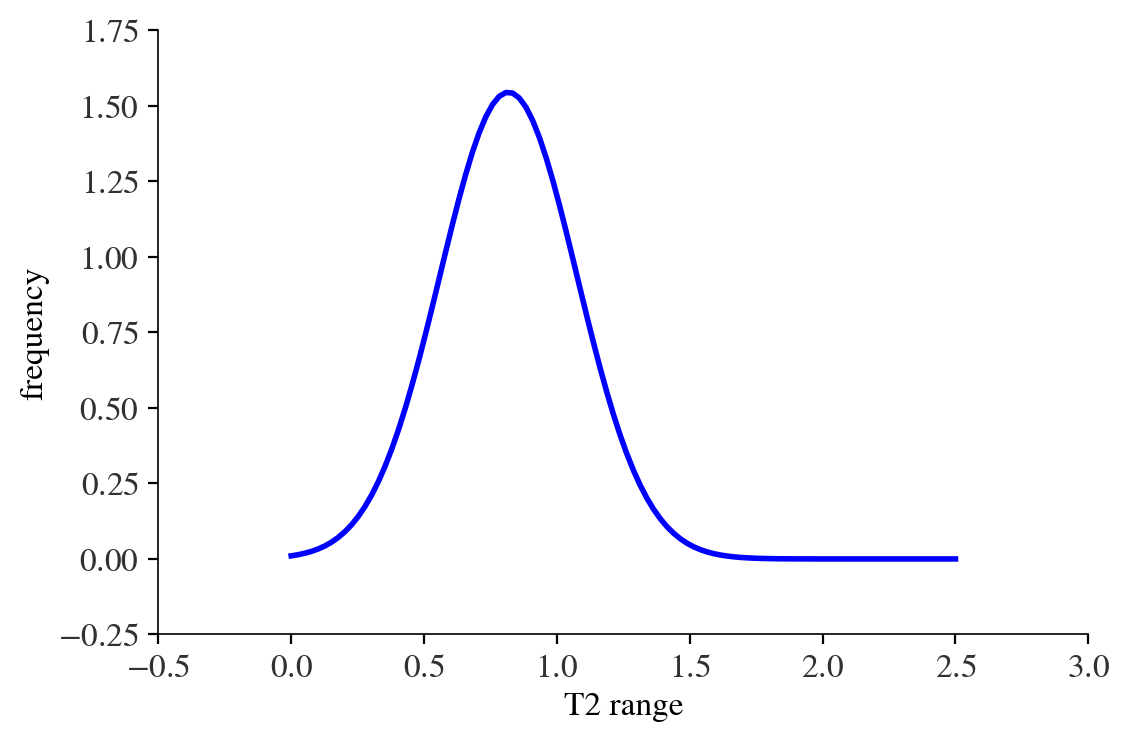

In [17]:
print()

plt.figure()
plt.plot(x_R,y_R,'b-')
#plt.hist(T2_range,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('T2 range')
plt.ylabel('frequency')
#plt.title("T2 distribution for 1.1% C13 ")

plt.savefig("goodnessoffit_averageT2.png")

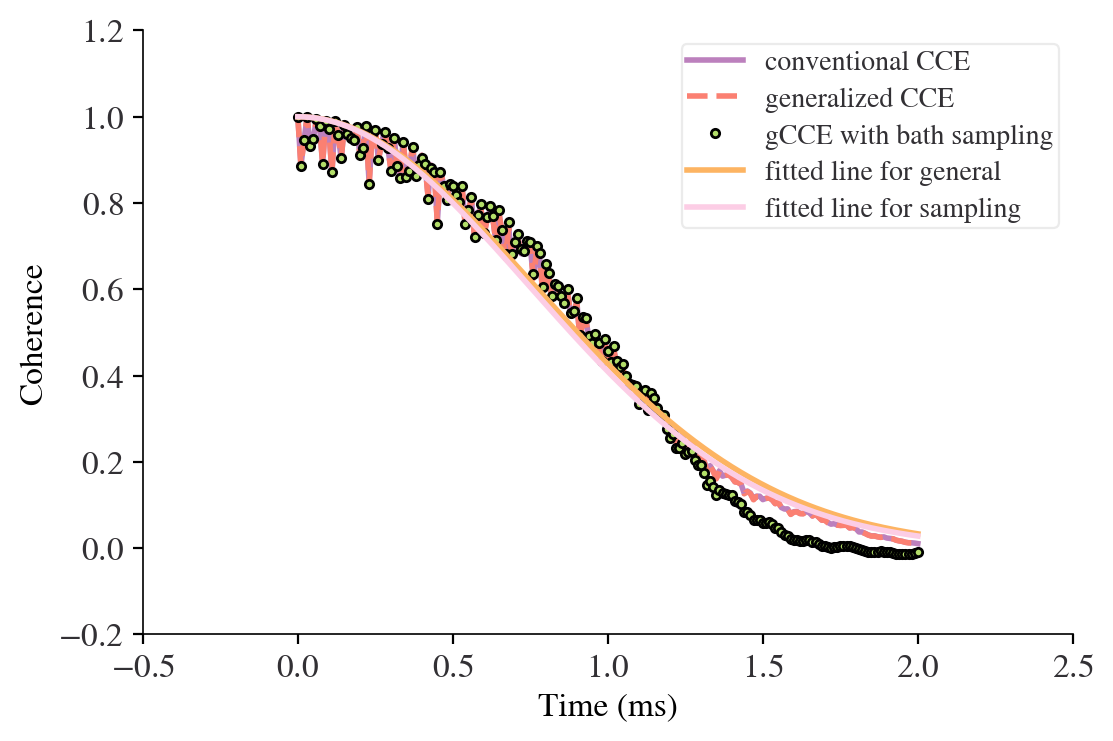

In [23]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8805.png")

In [24]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 27.115132113132567
the degree of freedom is 199
the reduced chi^2 is 0.13625694529212345
Fitted Gaussian: 
 Mean value  -0.05978441721403025 with standard deviation 0.3623906431602272


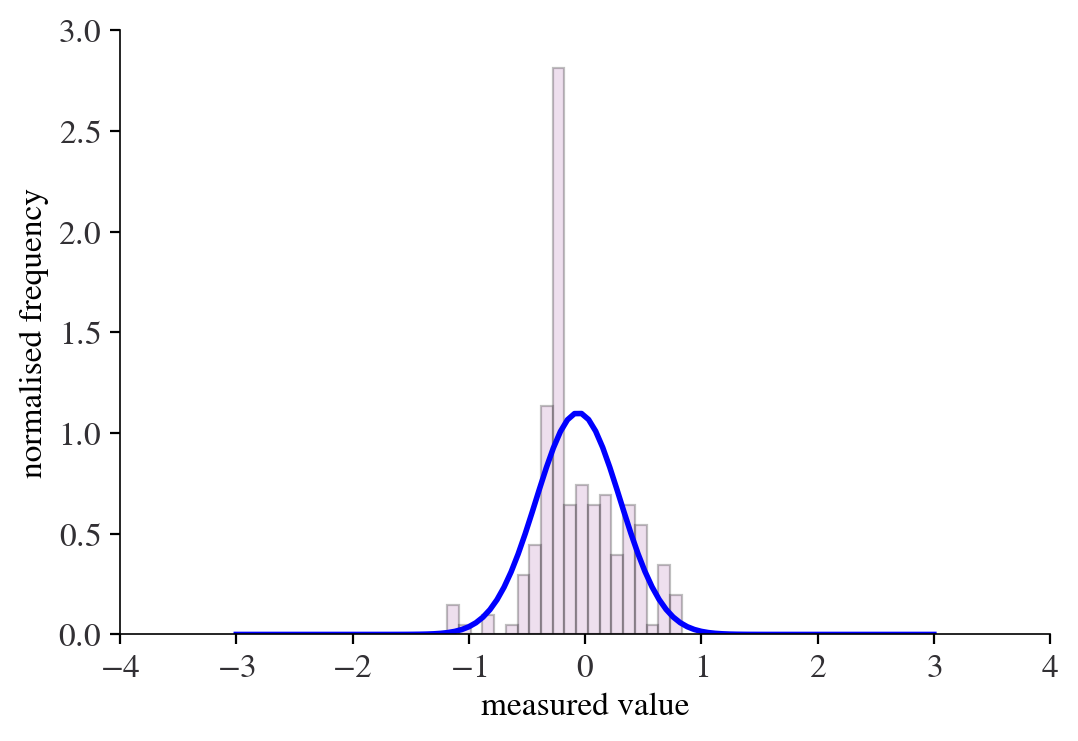

In [25]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8805.png")

In [26]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 61.780809145833345
the degree of freedom is 199
the reduced chi^2 is 0.3104563273659967
Fitted Gaussian: 
 Mean value  -0.10412128793403432 with standard deviation 0.5445419791712305


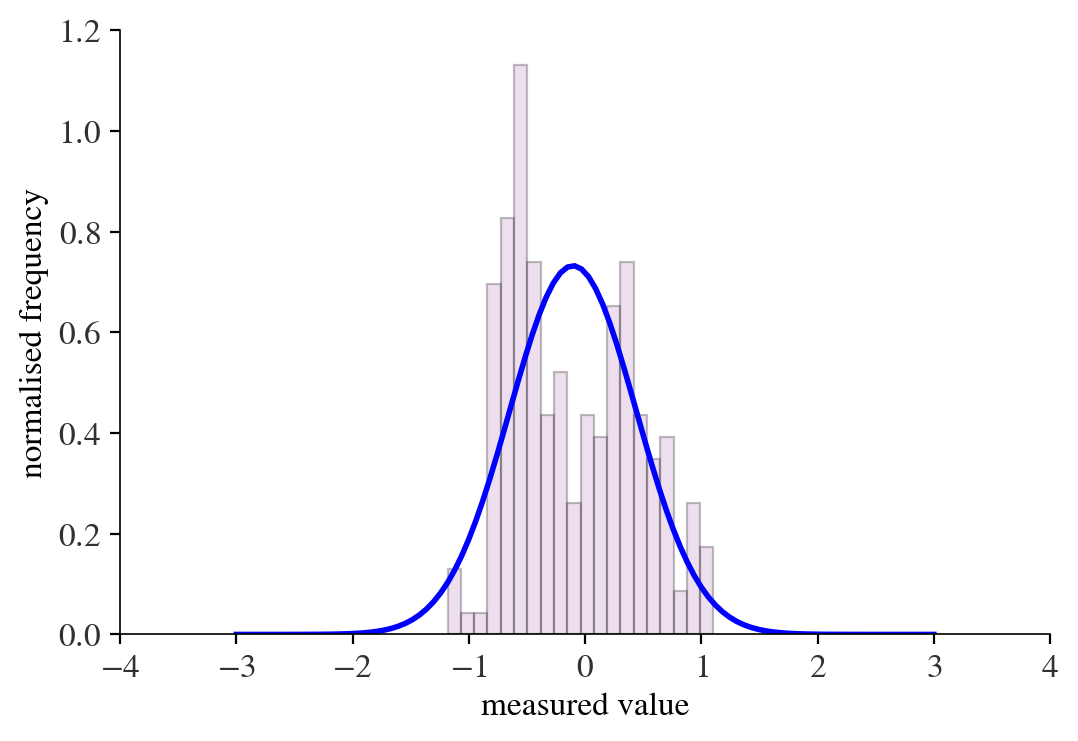

In [27]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8805.png")

### seed 8100

In [28]:
"""set up seed for decoherence calculation"""
seed = 8100
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.86236]
pcov_gen :
 [[0.00034]]
popt_samp :
 [1.03415]
pcov_samp :
 [[0.00047]]


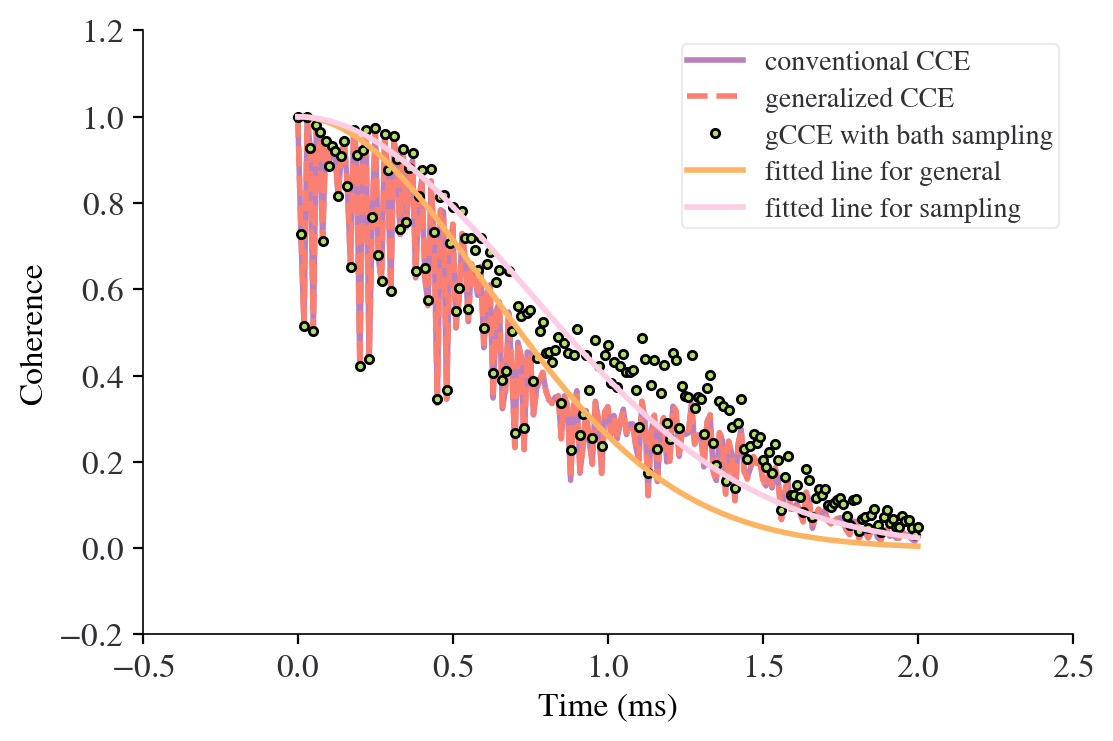

In [29]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8100.png")

In [30]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 365.52107087784344
the degree of freedom is 199
the reduced chi^2 is 1.8367893008936858
Fitted Gaussian: 
 Mean value  -0.05744036073061138 with standard deviation 1.3472985546626886


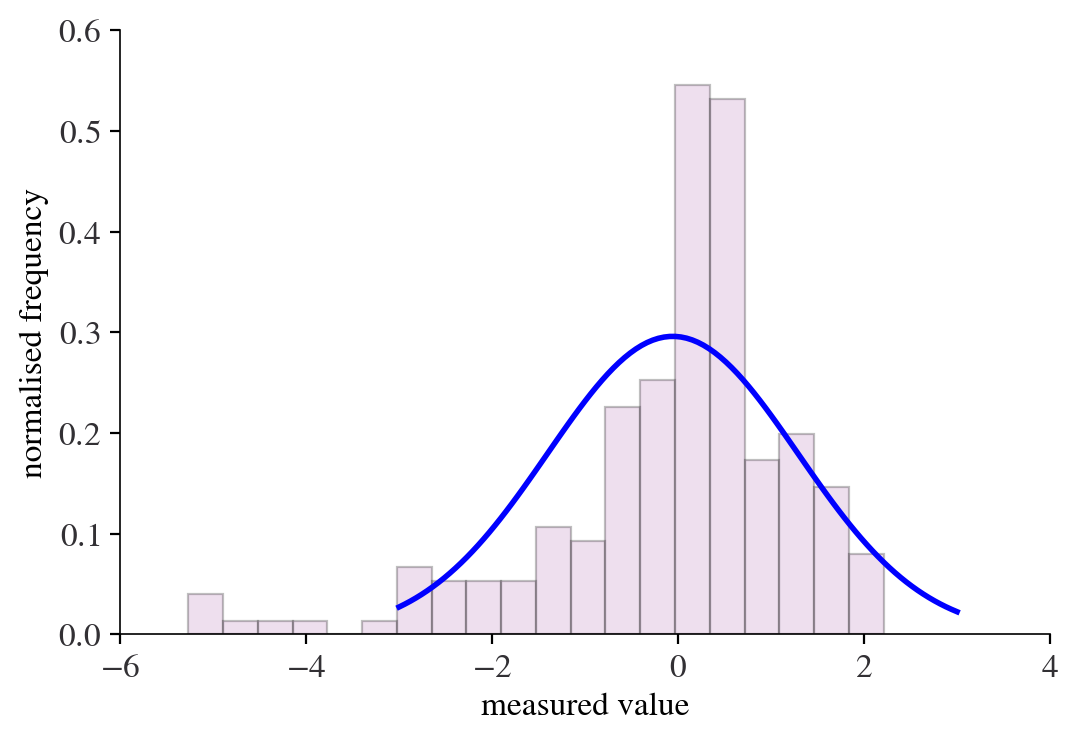

In [31]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8100.png")

In [32]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 419.05446800963887
the degree of freedom is 199
the reduced chi^2 is 2.105801346782105
Fitted Gaussian: 
 Mean value  -0.2533831554855154 with standard deviation 1.4214939592086366


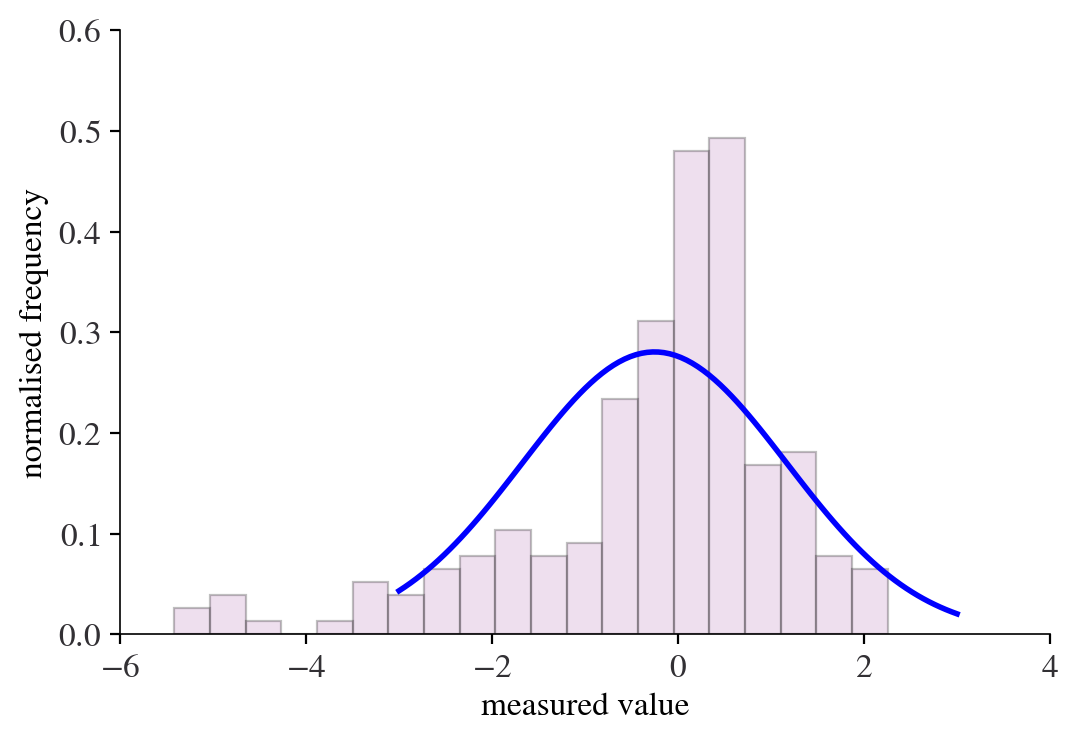

In [33]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8100.png")

### seed 8200

In [34]:
"""set up seed for decoherence calculation"""
seed = 8200
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.79167]
pcov_gen :
 [[0.00002]]
popt_samp :
 [0.83615]
pcov_samp :
 [[0.00002]]


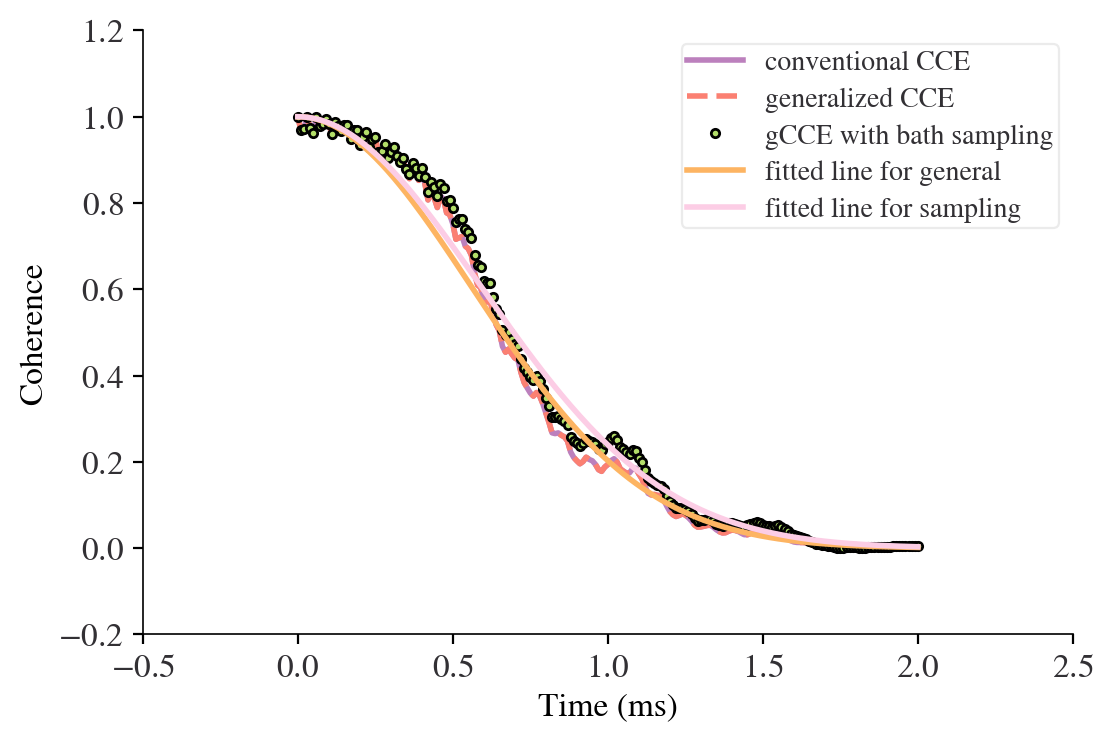

In [35]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8200.png")

In [36]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 25.385304990103432
the degree of freedom is 199
the reduced chi^2 is 0.12756434668393685
Fitted Gaussian: 
 Mean value  0.036991342117712676 with standard deviation 0.3534496998305946


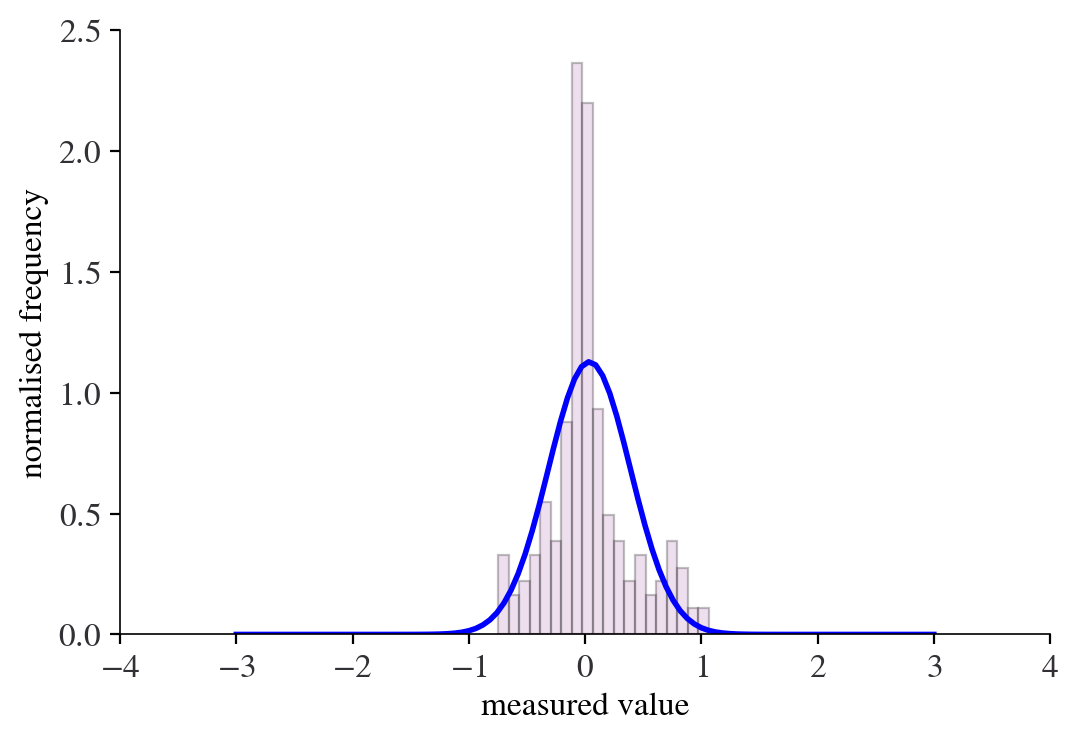

In [37]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8200.png")

In [38]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 26.75056896700249
the degree of freedom is 199
the reduced chi^2 is 0.1344249696834296
Fitted Gaussian: 
 Mean value  0.0373216709477013 with standard deviation 0.36289736933974015


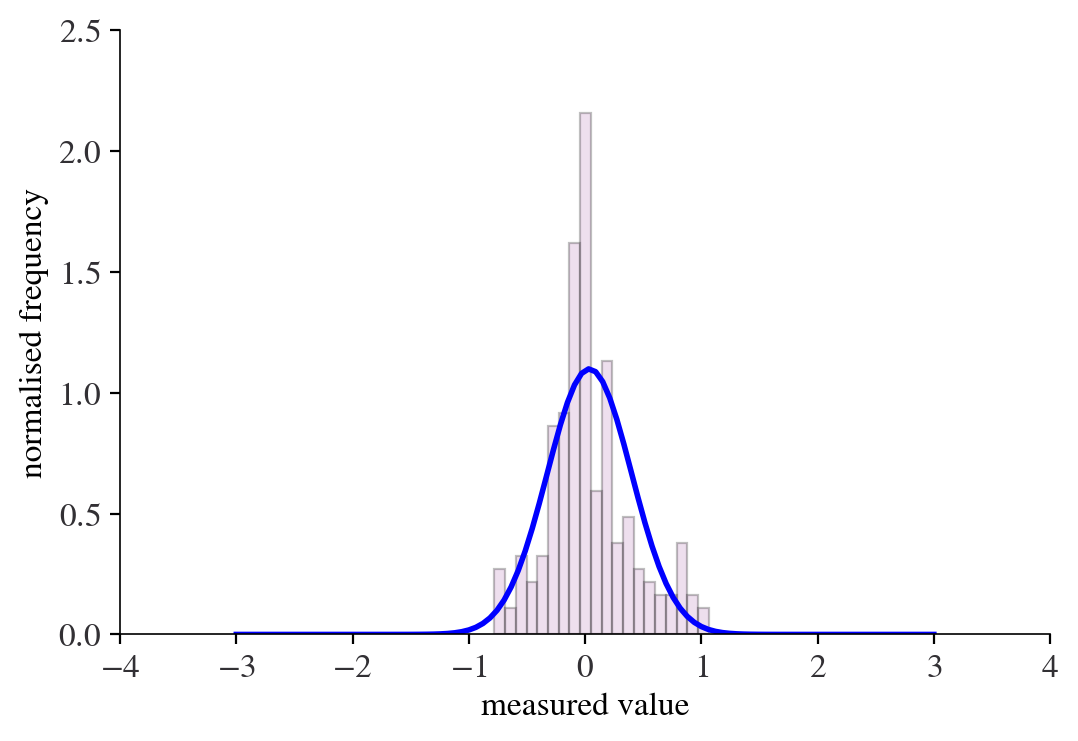

In [39]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8200.png")

### seed 8300

In [40]:
"""set up seed for decoherence calculation"""
seed = 8300
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.56917]
pcov_gen :
 [[0.00049]]
popt_samp :
 [0.61457]
pcov_samp :
 [[0.00057]]


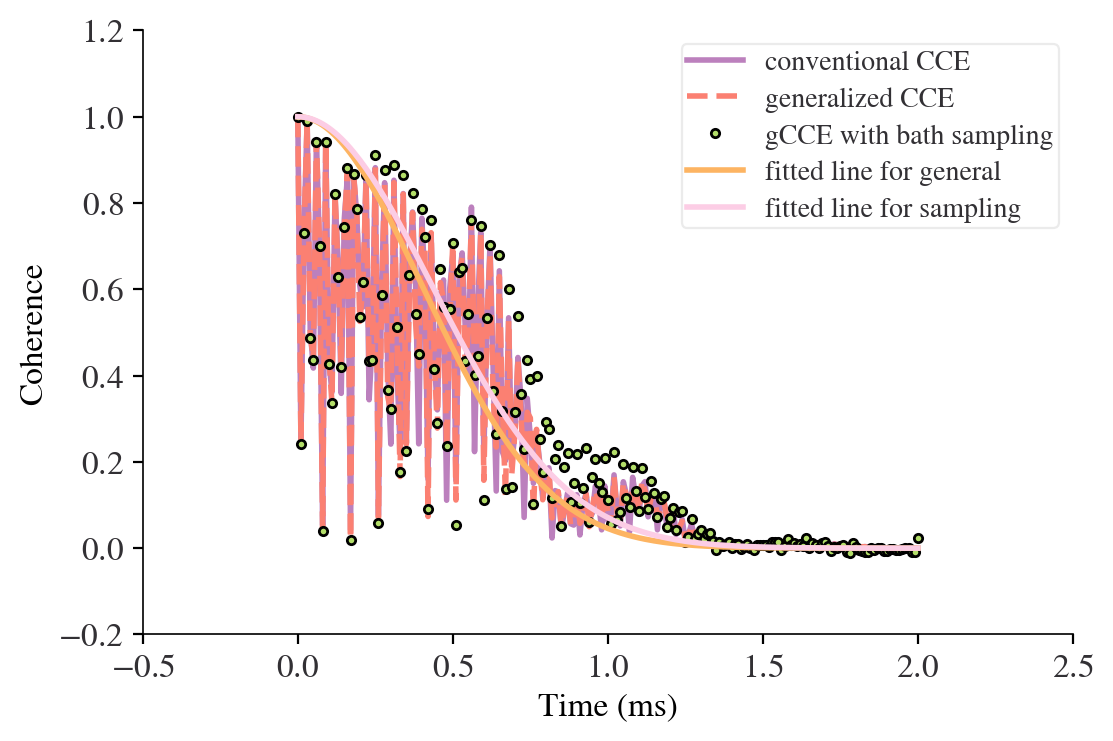

In [41]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8300.png")

In [42]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 806.7134452717896
the degree of freedom is 199
the reduced chi^2 is 4.053836408400953
Fitted Gaussian: 
 Mean value  -0.31605198955992386 with standard deviation 1.9782848297491338


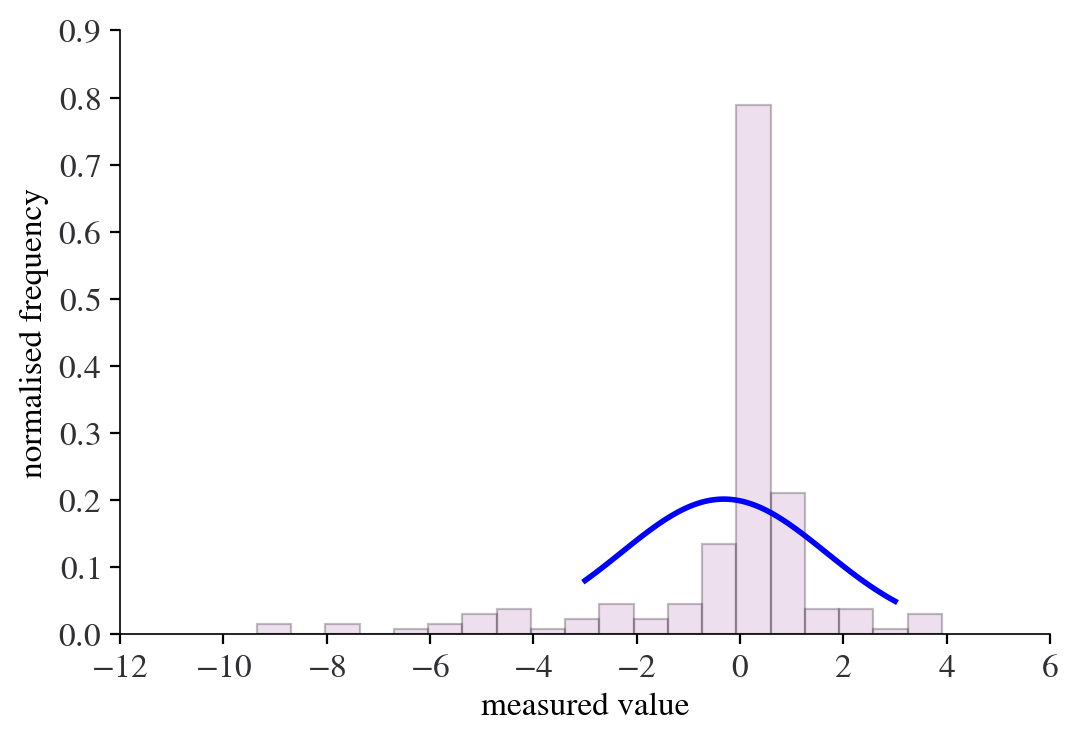

In [43]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8300.png")

In [44]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 868.6159484992758
the degree of freedom is 199
the reduced chi^2 is 4.364904263815456
Fitted Gaussian: 
 Mean value  -0.3560176218054236 with standard deviation 2.0481024958623095


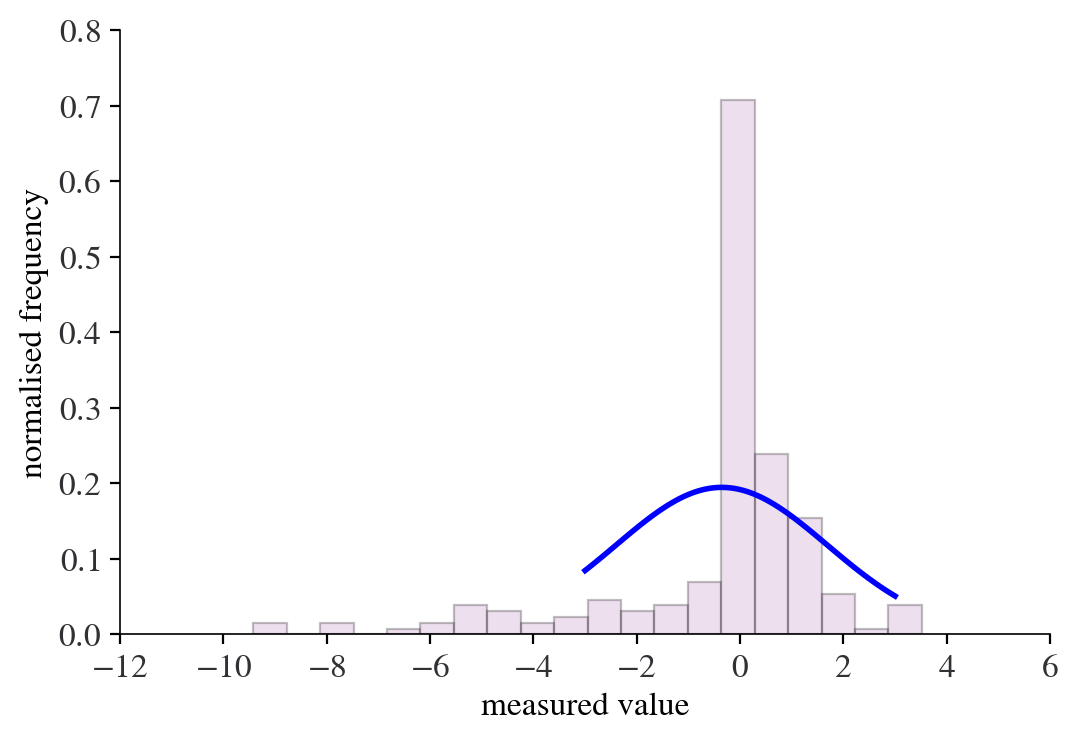

In [45]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8300.png")

### seed 8400

In [70]:
"""set up seed for decoherence calculation"""
seed = 8400
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.68837]
pcov_gen :
 [[0.00033]]
popt_samp :
 [0.65545]
pcov_samp :
 [[0.00046]]


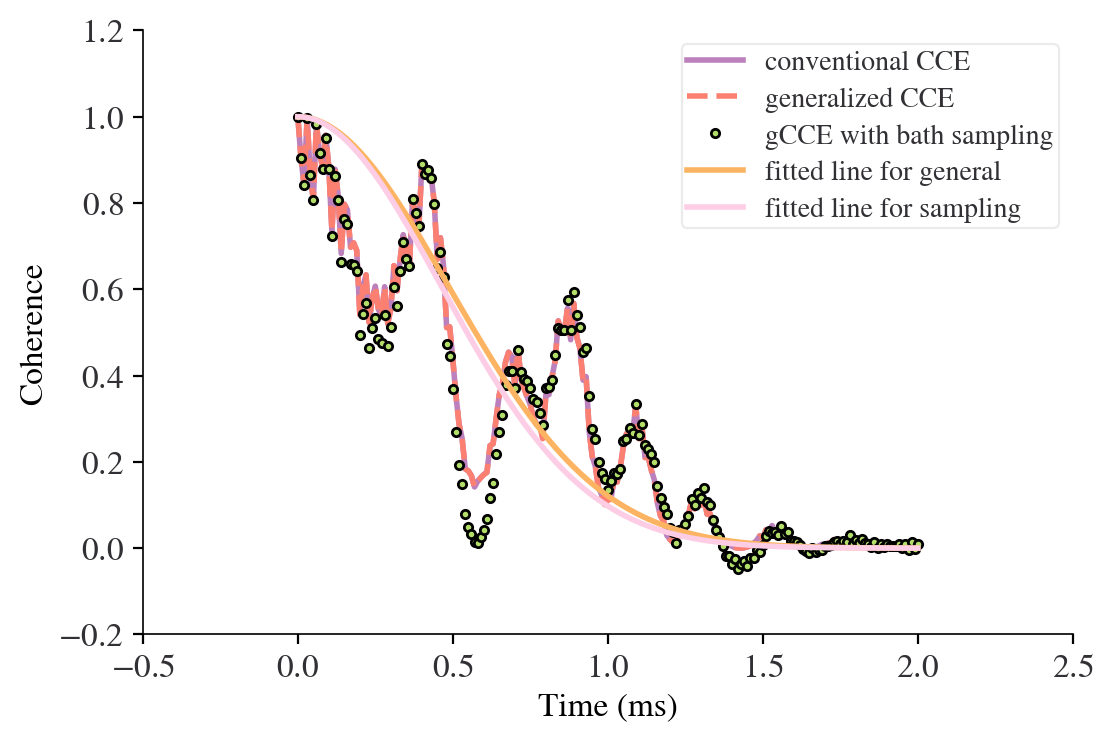

In [71]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8400.png")

In [72]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 445.3350040356953
the degree of freedom is 199
the reduced chi^2 is 2.2378643418879163
Fitted Gaussian: 
 Mean value  -0.14128496655594674 with standard deviation 1.4817677258021056


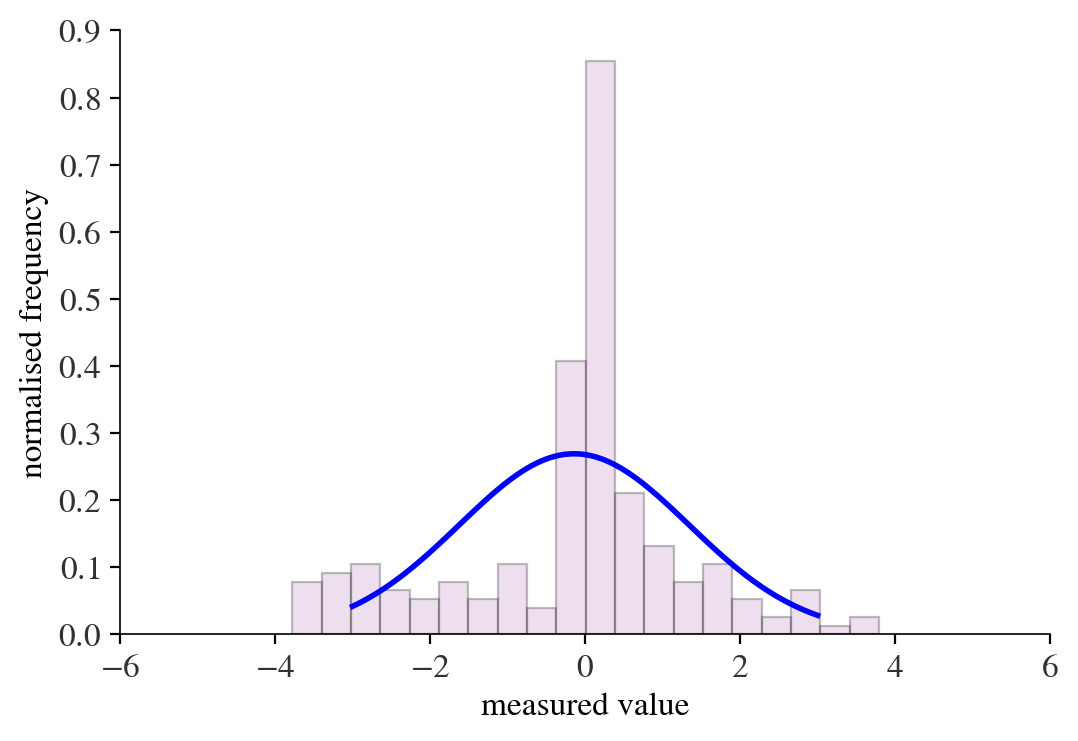

In [73]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8400.png")

In [74]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 656.1992702278889
the degree of freedom is 199
the reduced chi^2 is 3.297483769989391
Fitted Gaussian: 
 Mean value  -0.10308447323975889 with standard deviation 1.803897607289639


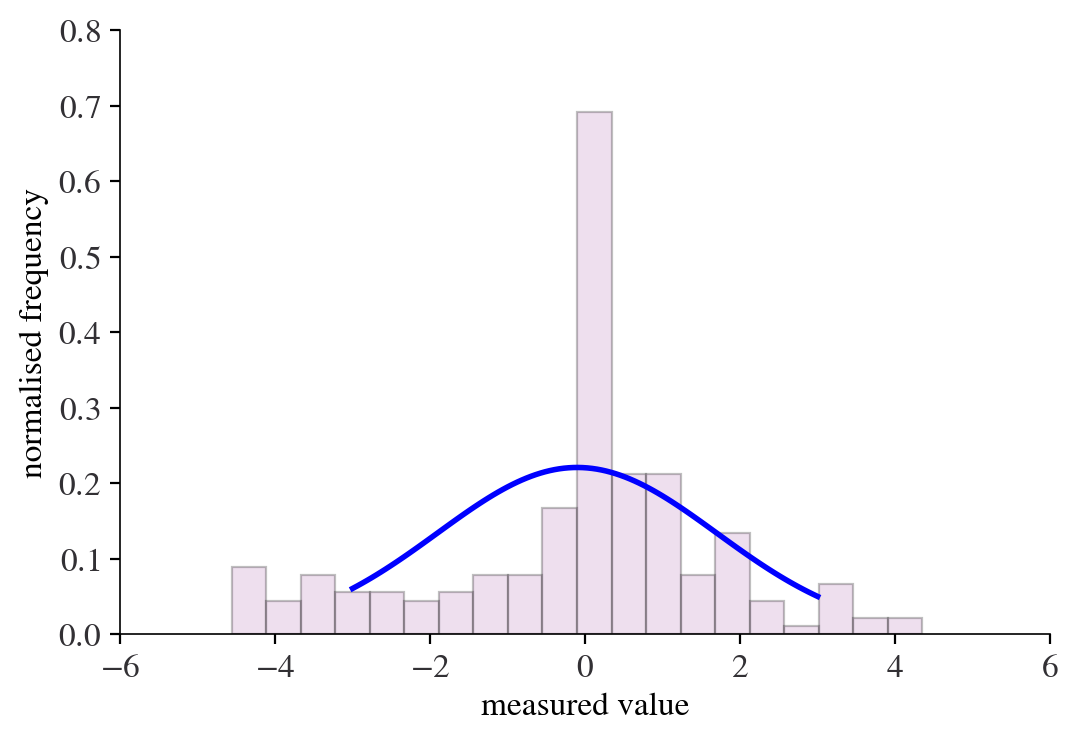

In [75]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8400.png")

### seed 8500

In [51]:
"""set up seed for decoherence calculation"""
seed = 8500
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.96432]
pcov_gen :
 [[0.00004]]
popt_samp :
 [0.98768]
pcov_samp :
 [[0.00003]]


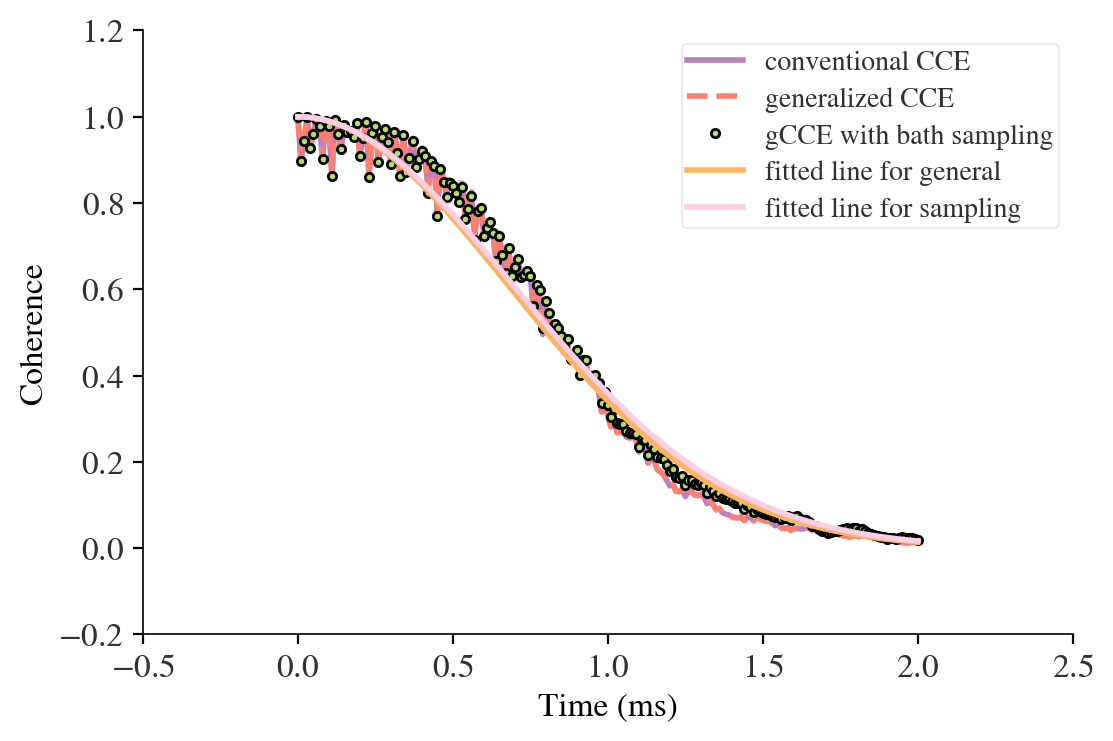

In [52]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8500.png")

In [53]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 41.46285217469321
the degree of freedom is 199
the reduced chi^2 is 0.20835604107886035
Fitted Gaussian: 
 Mean value  -0.003634363417074533 with standard deviation 0.454169173373554


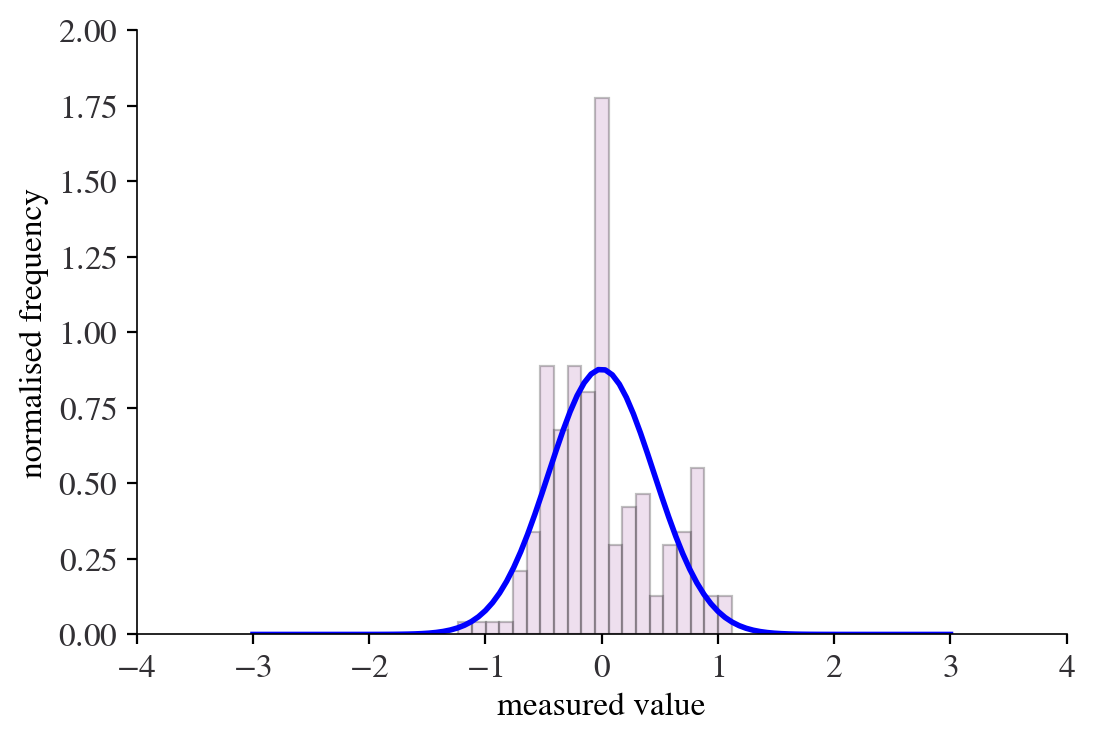

In [54]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8500.png")

In [55]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 29.61488031429778
the degree of freedom is 199
the reduced chi^2 is 0.1488184940416974
Fitted Gaussian: 
 Mean value  0.0011950575001704357 with standard deviation 0.38384408923940444


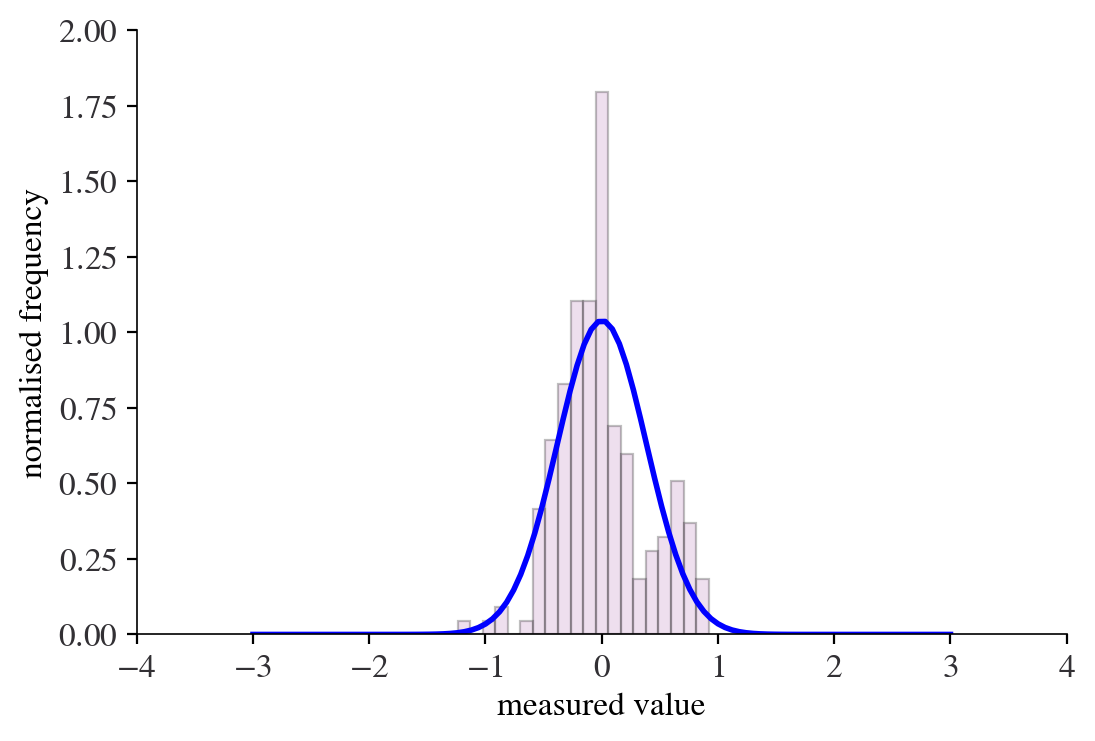

In [56]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8500.png")

### seed 8600

In [79]:
"""set up seed for decoherence calculation"""
seed = 8600
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.51653]
pcov_gen :
 [[0.00143]]
popt_samp :
 [0.52581]
pcov_samp :
 [[0.00106]]


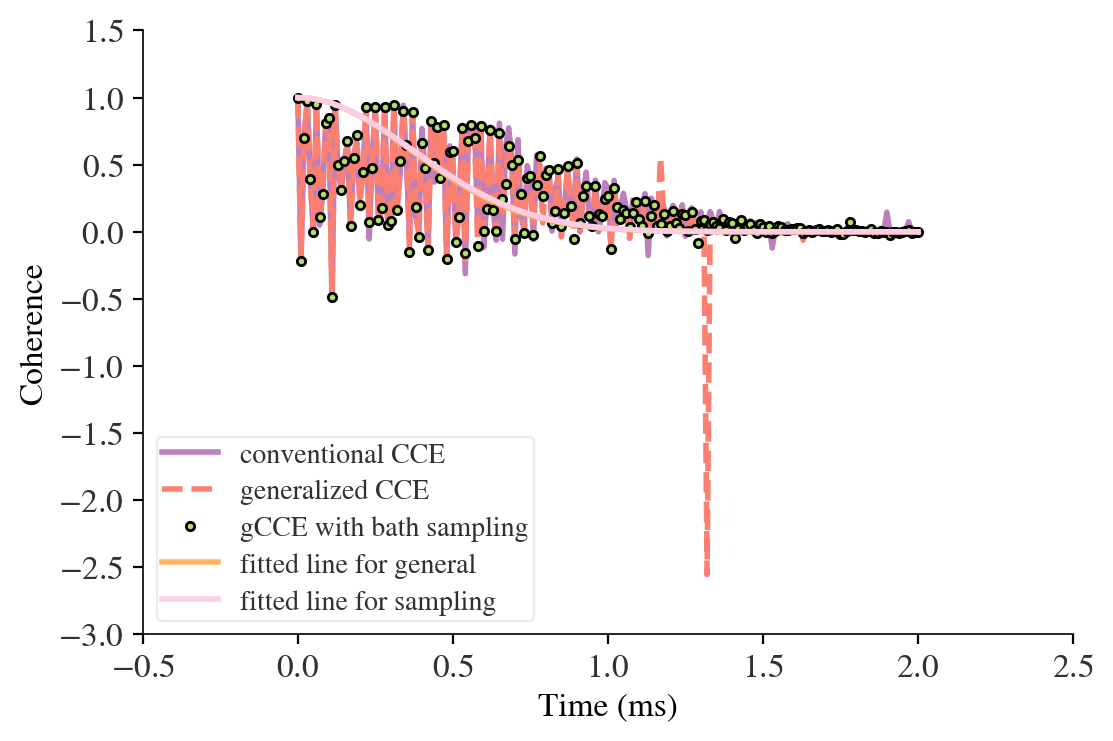

In [80]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8600.png")

In [59]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 2594.7729949720797
the degree of freedom is 199
the reduced chi^2 is 13.039060276241607
Fitted Gaussian: 
 Mean value  -0.33244003152924667 with standard deviation 3.577541335663713


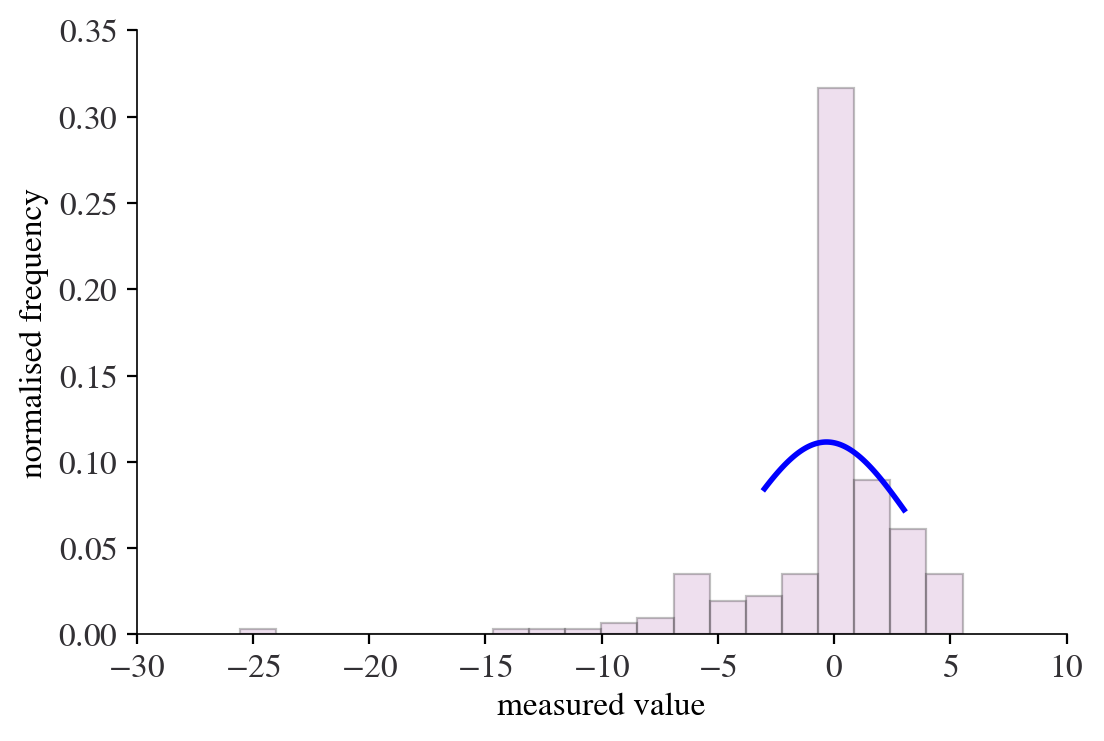

In [60]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8600.png")

In [61]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 1920.2852303518628
the degree of freedom is 199
the reduced chi^2 is 9.64967452438122
Fitted Gaussian: 
 Mean value  -0.20729826657774647 with standard deviation 3.083939897456003


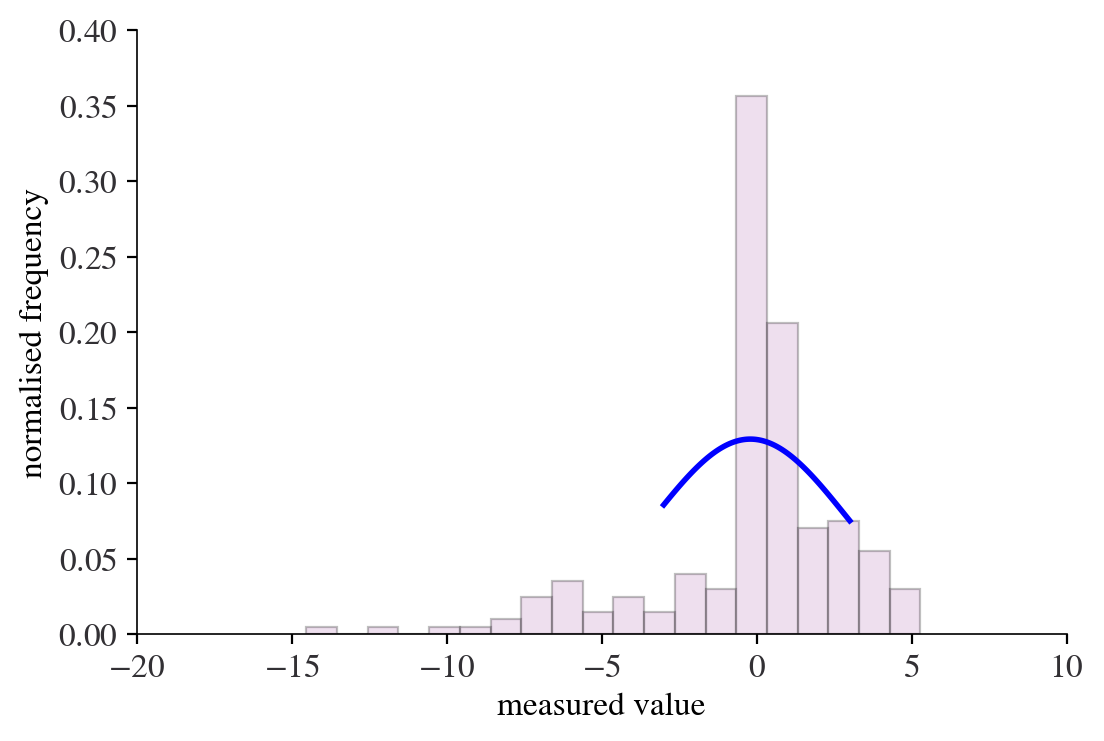

In [62]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8600.png")

### seed 8700

In [76]:
"""set up seed for decoherence calculation"""
seed = 8700
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1
T2_samp = popt2

y_gen = coherence_fit(time_space, T2_gen)   # calculates the y value using the Gaussian function
y_samp = coherence_fit(time_space, T2_samp)



popt_gen :
 [0.91159]
pcov_gen :
 [[0.00003]]
popt_samp :
 [0.99645]
pcov_samp :
 [[0.00005]]


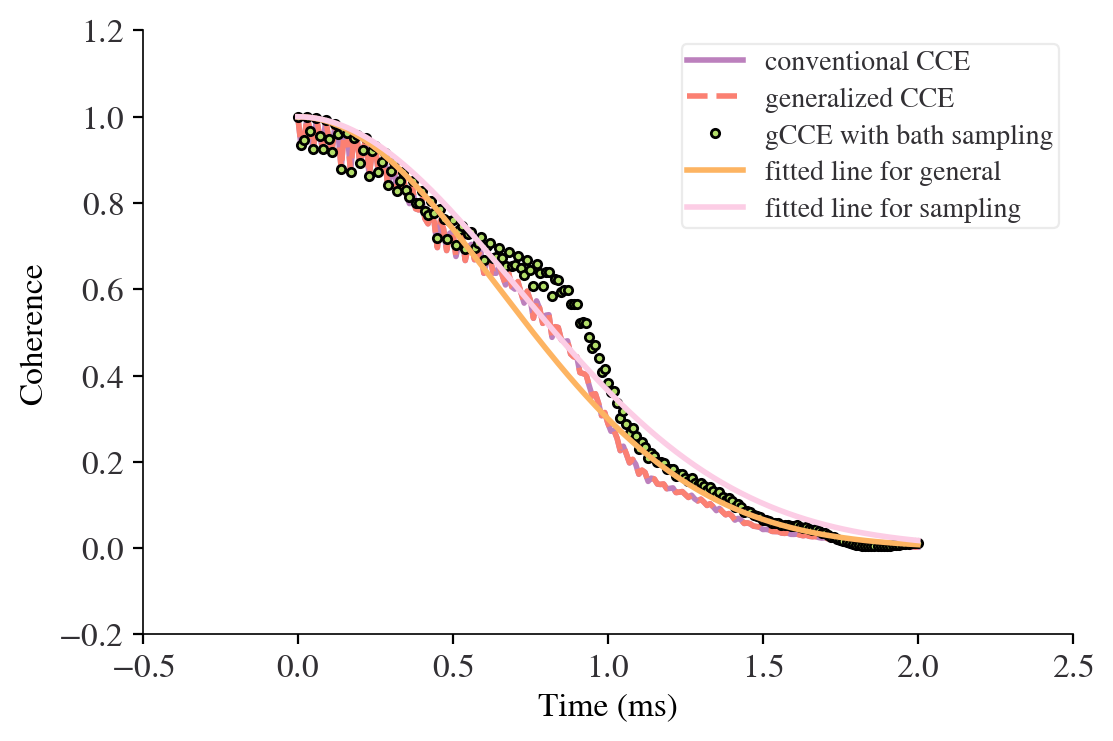

In [78]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')


plt.plot(time_space,y_gen,'-', label='fitted line for general')
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_seed8700.png")

In [65]:
""" gaussian fit test for general cce """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_generatilze.real - coherence_fit(time_space, T2_gen))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_generatilze.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 


the sum of squares of residuals is 28.32463438563059
the degree of freedom is 199
the reduced chi^2 is 0.14233484615894768
Fitted Gaussian: 
 Mean value  -0.09436741673146812 with standard deviation 0.36333644145945143


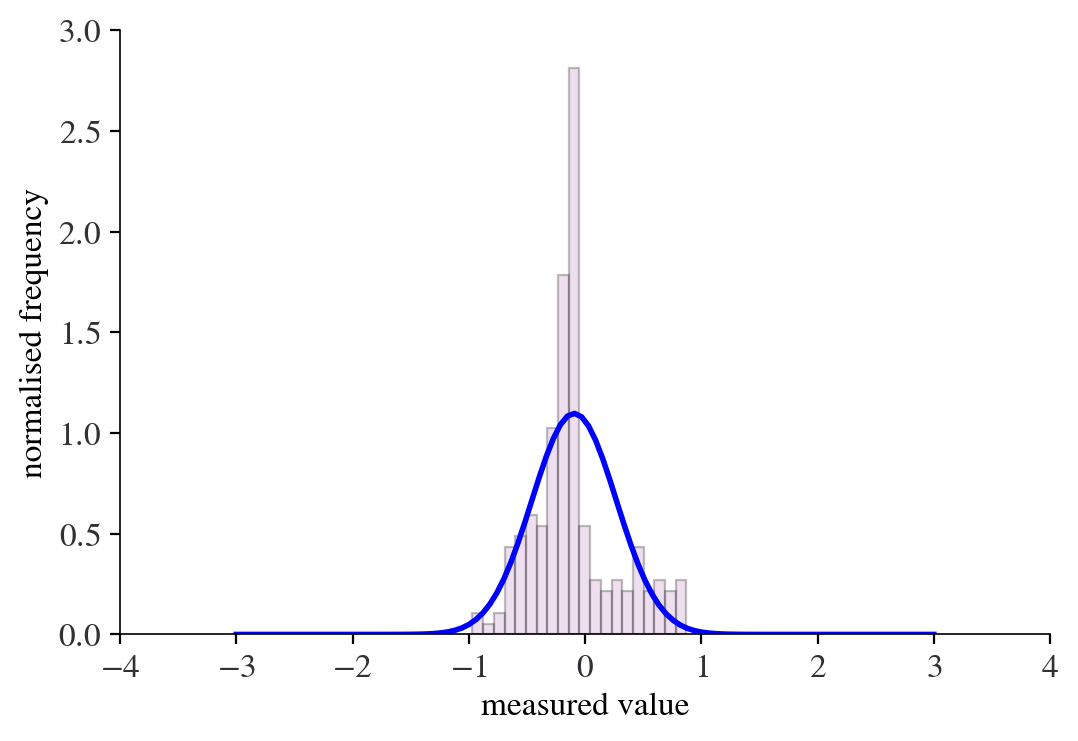

In [66]:

plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
#title_label=(f'Line fitted(for general cce) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_general_seed8700.png")

In [67]:
""" gaussian fit test for general cce with bath sampling """

yerror = 0.1                                                          # sets the accounted error for data V
residuals = (l_gcce.real - coherence_fit(time_space, T2_samp))/yerror      # calculates residuals for the points
square_of_residuals = residuals**2                                  # calculates their squares
sum_of_squares = np.sum(square_of_residuals)                        # calculates the sum of all the squared residuals

num_of_data = len(l_gcce.real)               # counts the number of data
num_of_para = 2                       # number of parameters in the fitting Gaussian is 4
dof = num_of_data - num_of_para       # calculates the number of degrees of freedom
reduced_chi2 = sum_of_squares/dof      # calculates the reduced chi^2

# prints the required values
print("the sum of squares of residuals is", sum_of_squares)
print("the degree of freedom is", dof)
print("the reduced chi^2 is", reduced_chi2)


x0, sigma = stats.norm.fit(residuals)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

x_R = np.linspace(-3,3,100)
y_R = Gaussianfit(x_R,x0,sigma) 



the sum of squares of residuals is 27.31003556177827
the degree of freedom is 199
the reduced chi^2 is 0.13723635960692598
Fitted Gaussian: 
 Mean value  -0.06416842723370295 with standard deviation 0.36297828672909915


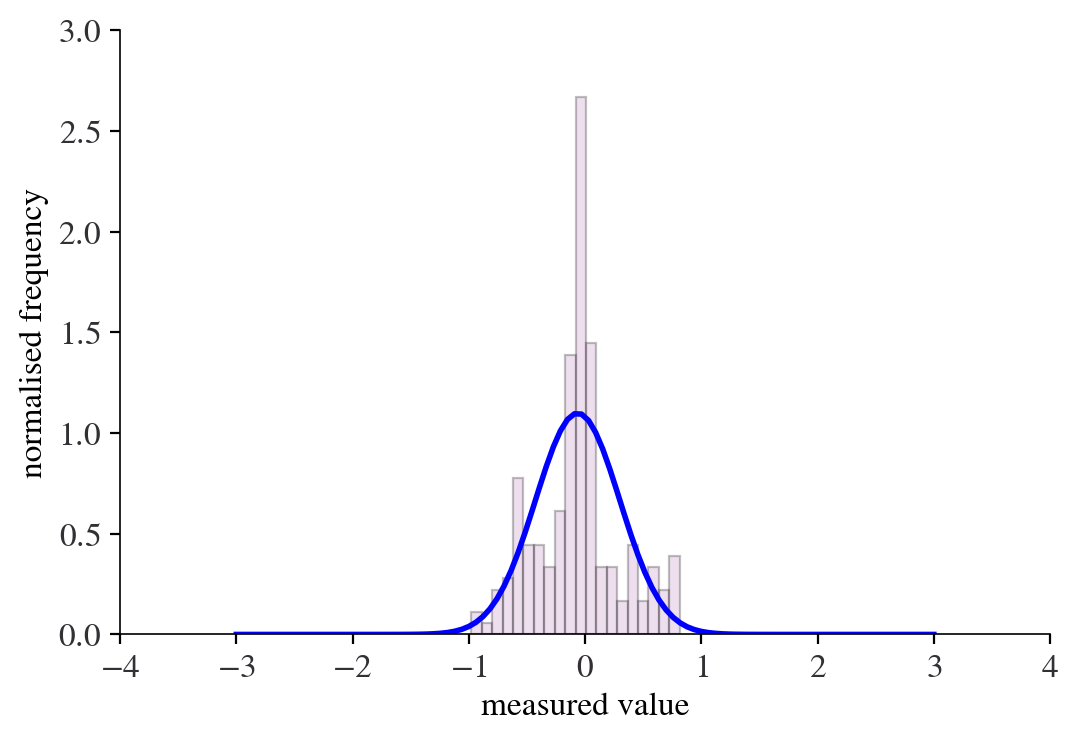

In [68]:
plt.figure()
plt.plot(x_R,y_R,'b-')
plt.hist(residuals,bins=20,density=True,alpha=0.25,edgecolor='k')
plt.xlabel('measured value')
plt.ylabel('normalised frequency')
title_label=(f'Line fitted(for bath sampling) with Gaussian $x_0$ = {x0:8.2e}, $\sigma$ = {sigma:8.2e}')
#plt.title(title_label)
plt.savefig("GoodnessOfFitTest_bathsampling_seed8700.png")

## distribution of T2 over 2000 bath spin distribution

### run 1

In [8]:
import time

""" calculate distribution of T2 over random bath spin distribution """

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 50  # in A
# Cluster cutoff radius
r_dipole = 10  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit

#########################################################################################################

T2_C = []
T2_C_err = []

seed_number = np.arange(7000,9000)
n=0
for i in seed_number:
    starttime = time.perf_counter()
    n=n+1
    seed=i
    np.random.seed(seed)
    "generate bath spins"
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=('14N', [0.5, 0.5, 0.5]), seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general CCE"
    # Time points
    time_space = np.linspace(0, 2, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_C.append(T2_gen[0])
    T2_C_err.append(T2_var[0][0])
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    


-12.759909100015648 secs for calc 1
-14.0490601999918 secs for calc 2
-14.725460699992254 secs for calc 3
-12.62372899998445 secs for calc 4
-12.812390599981882 secs for calc 5
-14.043342200049665 secs for calc 6
-13.332279000023846 secs for calc 7
-13.285945800016634 secs for calc 8
-13.147539700032212 secs for calc 9
-13.561170800006948 secs for calc 10
-12.928359999961685 secs for calc 11
-13.66807269997662 secs for calc 12
-13.67987799999537 secs for calc 13
-13.115014599985443 secs for calc 14
-12.966958999983035 secs for calc 15
-12.897517899982631 secs for calc 16
-12.52725439995993 secs for calc 17
-13.723794399993494 secs for calc 18
-16.82603019999806 secs for calc 19
-14.376273300033063 secs for calc 20
-13.619431299972348 secs for calc 21
-14.638179300003685 secs for calc 22
-14.273598600004334 secs for calc 23
-14.343129199987743 secs for calc 24
-12.93282350001391 secs for calc 25
-14.218918700003996 secs for calc 26
-16.04213500005426 secs for calc 27
-14.178223999973852

-11.974445100058801 secs for calc 221
-12.500349899986759 secs for calc 222
-12.923814700101502 secs for calc 223
-13.879568199976347 secs for calc 224
-12.47521649999544 secs for calc 225
-17.064619600074366 secs for calc 226
-14.908270999905653 secs for calc 227
-14.27186380000785 secs for calc 228
-12.488088099984452 secs for calc 229
-12.564151099999435 secs for calc 230
-12.066701099975035 secs for calc 231
-11.258370200055651 secs for calc 232
-12.106650699977763 secs for calc 233
-11.706356700044125 secs for calc 234
-11.84014029998798 secs for calc 235
-12.085369499982335 secs for calc 236
-11.070917700068094 secs for calc 237
-12.4133598000044 secs for calc 238
-12.035648000077344 secs for calc 239
-12.087602699990384 secs for calc 240
-11.587448199978098 secs for calc 241
-11.665401799953543 secs for calc 242
-11.08942929992918 secs for calc 243
-12.265226899995469 secs for calc 244
-11.360359700047411 secs for calc 245
-11.381744699901901 secs for calc 246
-12.08247859997209

-12.136537700076587 secs for calc 438
-12.621031499933451 secs for calc 439
-12.229731699917465 secs for calc 440
-13.001908599981107 secs for calc 441
-12.91726820007898 secs for calc 442
-12.716151500004344 secs for calc 443
-11.351158800069243 secs for calc 444
-12.360367499990389 secs for calc 445
-12.049533999990672 secs for calc 446
-12.499455600045621 secs for calc 447
-11.718304499983788 secs for calc 448
-11.94668230006937 secs for calc 449
-11.59687110001687 secs for calc 450
-11.470036000013351 secs for calc 451
-12.324204099946655 secs for calc 452
-11.792946700006723 secs for calc 453
-11.293554300093092 secs for calc 454
-11.079945700010285 secs for calc 455
-11.151009399909526 secs for calc 456
-12.372830500011332 secs for calc 457
-11.437581799924374 secs for calc 458
-11.632838199962862 secs for calc 459
-12.199465799960308 secs for calc 460
-12.09026160009671 secs for calc 461
-11.750427599996328 secs for calc 462
-11.637753900024109 secs for calc 463
-11.779817800037

-12.51832699996885 secs for calc 655
-13.132834299933165 secs for calc 656
-11.56546710000839 secs for calc 657
-12.616779300034977 secs for calc 658
-13.645080500049517 secs for calc 659
-12.582826699945144 secs for calc 660
-12.278801799984649 secs for calc 661
-13.351632299949415 secs for calc 662
-11.609705599956214 secs for calc 663
-12.283452900010161 secs for calc 664
-12.309874099912122 secs for calc 665
-12.406916399952024 secs for calc 666
-11.471203500055708 secs for calc 667
-12.112922200001776 secs for calc 668
-12.44199409999419 secs for calc 669
-11.120469699962996 secs for calc 670
-11.48261199996341 secs for calc 671
-12.311912899953313 secs for calc 672
-11.34598250000272 secs for calc 673
-11.918143199989572 secs for calc 674
-11.892701300093904 secs for calc 675
-13.198219600017183 secs for calc 676
-12.48884210002143 secs for calc 677
-12.570223500020802 secs for calc 678
-12.74985869997181 secs for calc 679
-11.835791799938306 secs for calc 680
-11.178630500100553

-11.617743899929337 secs for calc 872
-12.693797699990682 secs for calc 873
-12.328062399988994 secs for calc 874
-12.589381100027822 secs for calc 875
-11.135398699901998 secs for calc 876
-12.5058608999243 secs for calc 877
-14.097111899987794 secs for calc 878
-11.308100700029172 secs for calc 879
-12.326036400045268 secs for calc 880
-13.102847600006498 secs for calc 881
-12.335787300020456 secs for calc 882
-13.0930133999791 secs for calc 883
-12.454750100034289 secs for calc 884
-13.347347700037062 secs for calc 885
-12.007541700033471 secs for calc 886
-13.251098999986425 secs for calc 887
-12.05352179997135 secs for calc 888
-12.473127599922009 secs for calc 889
-12.288580299937166 secs for calc 890
-13.501704299938865 secs for calc 891
-11.465832299902104 secs for calc 892
-11.933012399938889 secs for calc 893
-12.128612499916926 secs for calc 894
-12.090005400008522 secs for calc 895
-12.942988099996 secs for calc 896
-11.694648299948312 secs for calc 897
-12.800245699938387 

-17.704181400011294 secs for calc 1087
-19.44113560009282 secs for calc 1088
-18.117578600067645 secs for calc 1089
-17.77096310001798 secs for calc 1090
-19.694628099910915 secs for calc 1091
-18.019965499988757 secs for calc 1092
-19.379071199917234 secs for calc 1093
-16.71418290003203 secs for calc 1094
-18.113623499986716 secs for calc 1095
-19.077745500020683 secs for calc 1096
-18.26522980001755 secs for calc 1097
-17.833170900004916 secs for calc 1098
-19.326837800093926 secs for calc 1099
-17.792679199948907 secs for calc 1100
-18.98222409992013 secs for calc 1101
-17.950001300079748 secs for calc 1102
-20.511842399952002 secs for calc 1103
-18.05145860009361 secs for calc 1104
-17.817696999991313 secs for calc 1105
-17.18288159999065 secs for calc 1106
-18.203700999962166 secs for calc 1107
-17.30460400006268 secs for calc 1108
-19.85916739993263 secs for calc 1109
-18.023366400040686 secs for calc 1110
-18.258580000023358 secs for calc 1111
-17.27696379995905 secs for calc 1

-14.561384300002828 secs for calc 1299
-14.605012399959378 secs for calc 1300
-15.313579499954358 secs for calc 1301
-13.066865800064988 secs for calc 1302
-12.951950800023042 secs for calc 1303
-11.778416399960406 secs for calc 1304
-13.661271399934776 secs for calc 1305
-12.577079500071704 secs for calc 1306
-11.59845900000073 secs for calc 1307
-11.583946999977343 secs for calc 1308
-12.190196999930777 secs for calc 1309
-11.115144900046289 secs for calc 1310
-12.59006059996318 secs for calc 1311
-12.696938099921681 secs for calc 1312
-11.628352999920025 secs for calc 1313
-11.785273400018923 secs for calc 1314
-11.818158300011419 secs for calc 1315
-12.157412800006568 secs for calc 1316
-11.482610899955034 secs for calc 1317
-10.941220099921338 secs for calc 1318
-10.949612600030378 secs for calc 1319
-12.278050599968992 secs for calc 1320
-11.861937999958172 secs for calc 1321
-12.427752800052986 secs for calc 1322
-12.0038504000986 secs for calc 1323
-10.82444380002562 secs for c

-12.848002700018696 secs for calc 1511
-12.62015460000839 secs for calc 1512
-11.993387299939059 secs for calc 1513
-12.830949500086717 secs for calc 1514
-11.883248400059529 secs for calc 1515
-12.336081300047226 secs for calc 1516
-12.79839000001084 secs for calc 1517
-11.300884100026451 secs for calc 1518
-11.538778700050898 secs for calc 1519
-11.302771299961023 secs for calc 1520
-11.418932700064033 secs for calc 1521
-11.927902100025676 secs for calc 1522
-13.241848099976778 secs for calc 1523
-11.4647968999343 secs for calc 1524
-11.367724800016731 secs for calc 1525
-12.72507789998781 secs for calc 1526
-12.340386600000784 secs for calc 1527
-11.366704600048251 secs for calc 1528
-11.584009799989872 secs for calc 1529
-11.375901599996723 secs for calc 1530
-11.086776799988002 secs for calc 1531
-12.07383020000998 secs for calc 1532
-13.585422200034373 secs for calc 1533
-11.623073399998248 secs for calc 1534
-12.226511099957861 secs for calc 1535
-12.428100700024515 secs for ca

-11.755744599970058 secs for calc 1723
-12.044008899945766 secs for calc 1724
-12.719974000006914 secs for calc 1725
-11.548203799990006 secs for calc 1726
-11.504867500043474 secs for calc 1727
-13.246251600096002 secs for calc 1728
-12.220992700080387 secs for calc 1729
-11.945156800094992 secs for calc 1730
-11.976289500016719 secs for calc 1731
-12.64289620006457 secs for calc 1732
-11.592839799937792 secs for calc 1733
-11.430866500013508 secs for calc 1734
-11.981026099994779 secs for calc 1735
-11.517903800006025 secs for calc 1736
-13.598511799937114 secs for calc 1737
-12.323564699967392 secs for calc 1738
-11.413678199984133 secs for calc 1739
-12.455603100010194 secs for calc 1740
-12.513219600077718 secs for calc 1741
-11.835640799952671 secs for calc 1742
-12.038540399982594 secs for calc 1743
-11.942210800014436 secs for calc 1744
-12.501434799982235 secs for calc 1745
-12.091656200005673 secs for calc 1746
-11.588967600022443 secs for calc 1747
-11.842621200019494 secs f

-12.546932599972934 secs for calc 1934
-12.326540700043552 secs for calc 1935
-11.885438100085594 secs for calc 1936
-11.776133799925447 secs for calc 1937
-11.927592700114474 secs for calc 1938
-12.68185169994831 secs for calc 1939
-11.388416099944152 secs for calc 1940
-10.98548709996976 secs for calc 1941
-11.521100100013427 secs for calc 1942
-12.046563199954107 secs for calc 1943
-11.956599900033325 secs for calc 1944
-11.141302299918607 secs for calc 1945
-12.516717700054869 secs for calc 1946
-11.067345699993894 secs for calc 1947
-11.780288100009784 secs for calc 1948
-12.129868799936958 secs for calc 1949
-11.182215600041673 secs for calc 1950
-11.887753100018017 secs for calc 1951
-11.738245900021866 secs for calc 1952
-12.00723340001423 secs for calc 1953
-12.289484399952926 secs for calc 1954
-11.888606499996968 secs for calc 1955
-12.120188000029884 secs for calc 1956
-11.29718660004437 secs for calc 1957
-10.813539800001308 secs for calc 1958
-12.554917000001296 secs for 

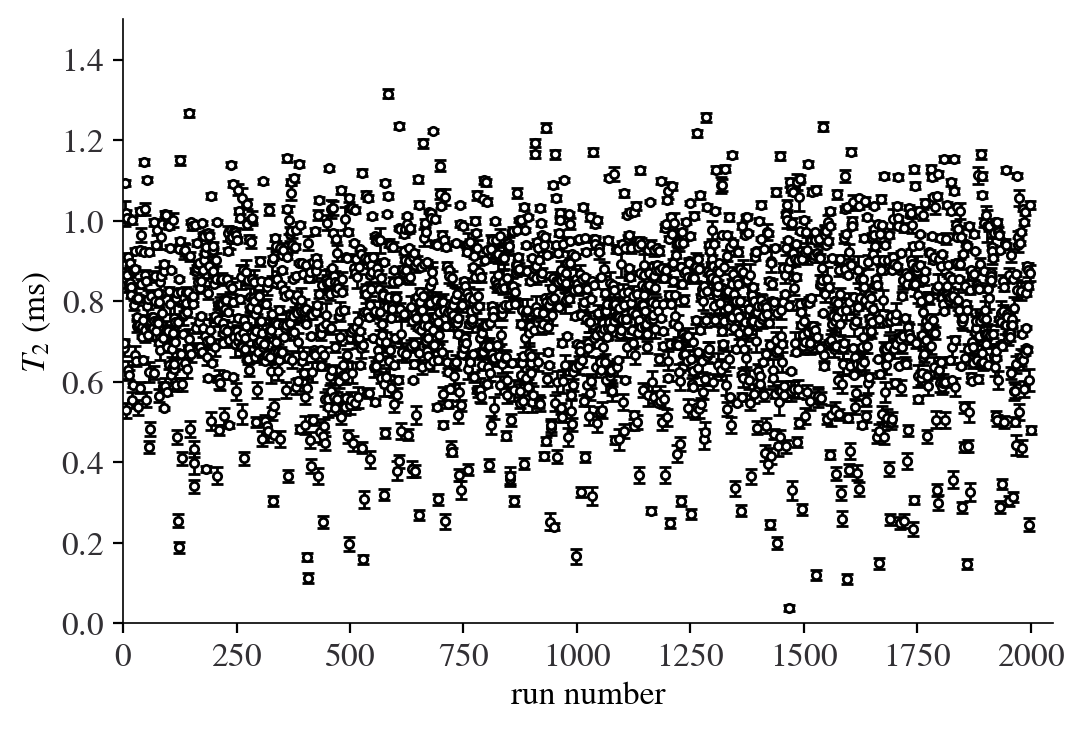

In [22]:

repeats = 2000
run_number = np.arange(1, repeats+1)

'save datapoints'
datasavefile = 'T2data_averageT2_7000to8999.csv'
data_C_T2 = {'run_number':run_number, 'T2_C':T2_C, 'T2_C_err':T2_C_err}
df = pd.DataFrame(data = data_C_T2)
df.to_csv(datasavefile)

""" plot and save distribution for T2 datapoints """

plt.figure()
plt.errorbar(run_number, T2_C, yerr=T2_C_err, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
plt.xlabel('run number')
plt.ylabel('$T_2$ (ms)')
plt.xlim(0,2050)
plt.ylim(0,1.5)
#plt.title("T2 distribution for average T2")

plt.savefig("T2data_7000to8999.png")

Fitted Gaussian: 
 Mean value  0.772150875828467 with standard deviation 0.18589516187402663
absolute uncertainty 24.07497908677153 %
1.7250069899573646 %
1.9709699093218411 %


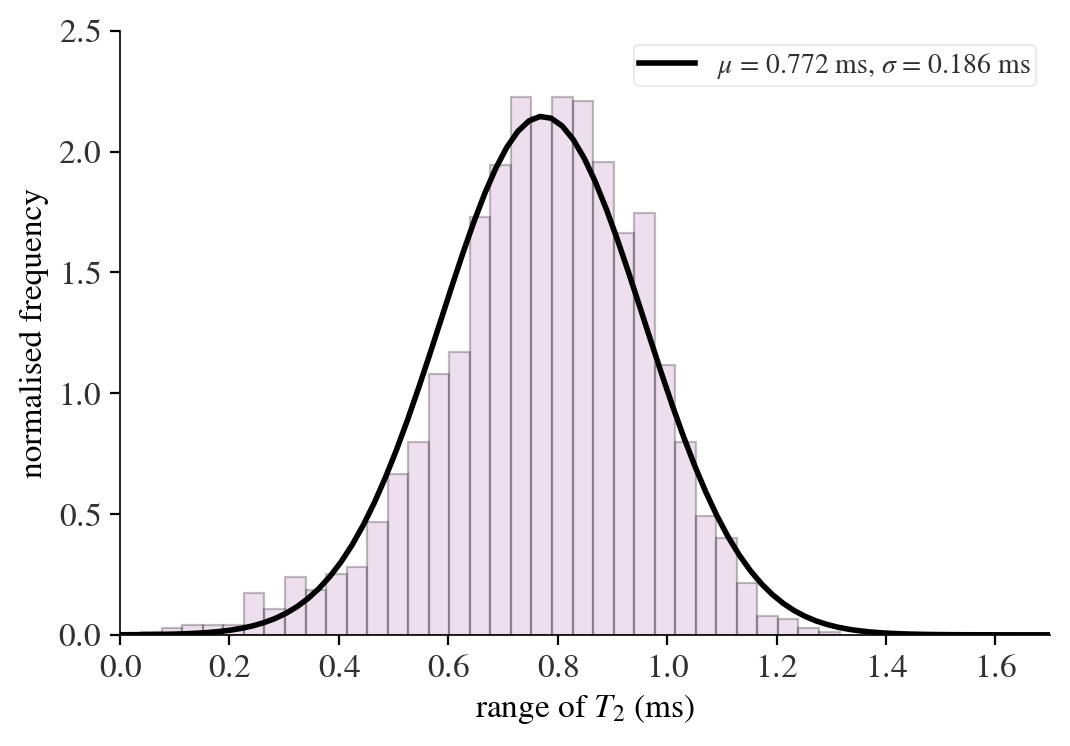

In [126]:
""" plot gaussian fit for distribution of T2 for 1.1% 13C """

x0, sigma = stats.norm.fit(T2_C)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)
T2_trueerror = sigma/x0
print('absolute uncertainty',T2_trueerror*100,'%')
T2_fiterror = np.sum(T2_C_err)/(2000*x0)
print(T2_fiterror*100,'%')
print(np.sum(np.divide(T2_C_err,T2_C))/20,'%')

def Gaussianfit(x,x0,sigma):                  # defines the term "Gaussianfit" to have the following function
    y = (np.exp((-(x - x0)**2)/(2*(sigma**2))))/(sigma*np.sqrt(2*np.pi))           
    return y                 # function for inputs of x, x0, and sigma, and outputs y

title_label=(f'$\mu$ = {x0:0.3f} ms, $\sigma$ = {sigma:0.3f} ms')

x_R = np.linspace(0,2,100)
y_R = Gaussianfit(x_R,x0,sigma) 

plt.figure()
plt.plot(x_R,y_R,'k-', label=title_label)
plt.hist(T2_C,bins='auto',density=True,alpha=0.25,edgecolor='k', label='')



plt.xlabel('range of $T_2$ (ms)')
plt.ylabel('normalised frequency')
plt.xlim(0.0,1.7)
plt.legend(loc='best')
#plt.title("T2 distribution for 1.1% C13 ")

plt.savefig("T2average_7000to8999.png")

In [103]:

x0, sigma = stats.norm.fit(T2_C)
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)
T2_poperror = sigma/x0
print('population uncertainty =',T2_poperror*100,'%')
T2_fiterror = np.sum(np.divide(T2_C_err,T2_C))/len(T2_C_err)
print('fit uncertainty =',T2_fiterror*100,'%')
T2_percenterror = T2_poperror + T2_fiterror
T2_abserror = T2_percenterror*x0
print('average T2',x0, '±',T2_abserror,'ms (',T2_percenterror*100,'%)')

Fitted Gaussian: 
 Mean value  0.772150875828467 with standard deviation 0.18589516187402663
population uncertainty = 24.07497908677153 %
fit uncertainty = 1.9709699093218414 %
average T2 0.772150875828467 ± 0.20111402329117076 ms ( 26.045948996093372 %)


## T2 range for varying 13C concentration

In [36]:
""" T2 range for varying 13C concentration """

"""set up seed for decoherence calculation"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

conc = np.linspace(0.002, 0.04, repeats)

T2_C_conc= []
T2_C_err_conc = []
n=0
for i in conc:
    starttime = time.perf_counter()
    n=n+1
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    # Add types of isotopes
    diamond.add_isotopes(('13C', i))
    diamond.isotopes['C']['14C'] = 0.001
    atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=('14N', [0.5, 0.5, 0.5]), seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general CCE"
    # Time points
    time_space = np.linspace(0, 2, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    
    T2_C_conc.append(T2_gen[0])
    T2_C_err_conc.append(T2_var[0][0])
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    


-0.8778657000511885 secs for calc 1
-1.232804900035262 secs for calc 2
-1.1789705000119284 secs for calc 3
-1.4927998000057414 secs for calc 4
-1.9210298999678344 secs for calc 5
-2.5358941999729723 secs for calc 6
-2.8393280000891536 secs for calc 7
-3.123979300027713 secs for calc 8
-3.6236200000857934 secs for calc 9
-4.171873399987817 secs for calc 10
-4.537621100083925 secs for calc 11
-4.716637100093067 secs for calc 12
-5.425087700015865 secs for calc 13
-6.010220899945125 secs for calc 14
-6.700959499925375 secs for calc 15
-6.903304300038144 secs for calc 16
-7.647193599957973 secs for calc 17
-8.33567420009058 secs for calc 18
-11.669332399964333 secs for calc 19
-12.844555399962701 secs for calc 20
-11.9376986999996 secs for calc 21
-13.131599699961953 secs for calc 22
-16.524622799945064 secs for calc 23
-13.462510799989104 secs for calc 24
-13.273138899938203 secs for calc 25
-15.112875599996187 secs for calc 26
-14.196097500040196 secs for calc 27
-15.879568799980916 secs

[0.61207 1.22612]
[[0.03206 0.0275 ]
 [0.0275  0.05322]]


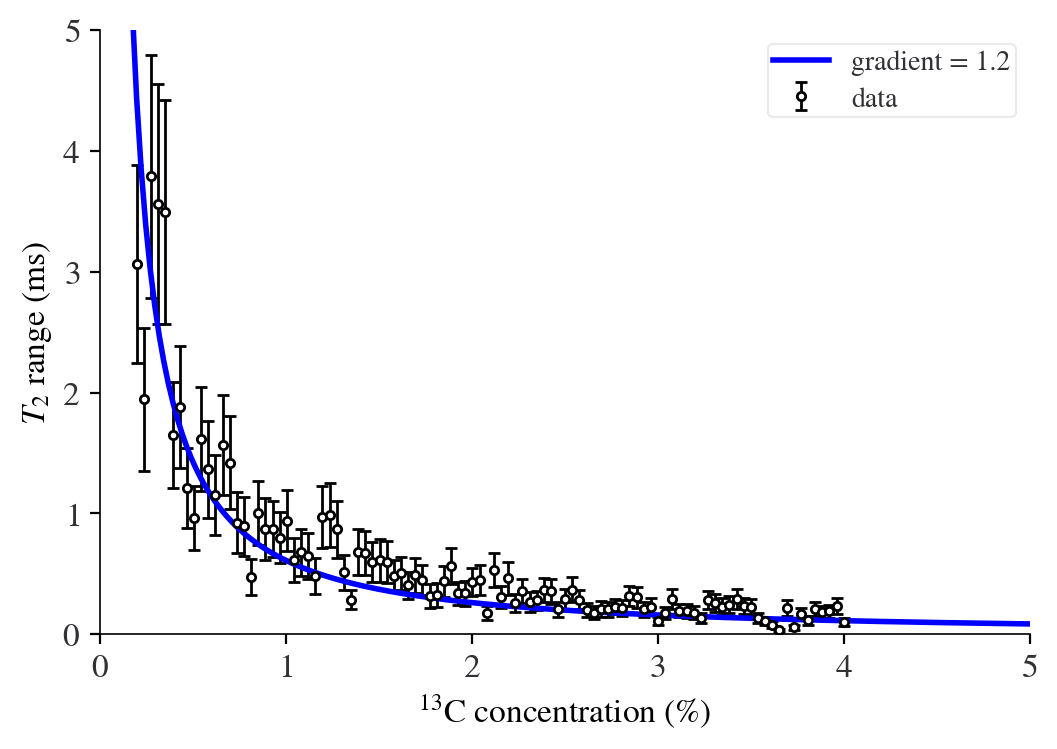

In [143]:
T2_C_trueerr_conc = np.multiply( np.add( np.divide( T2_C_err_conc,T2_C_conc ),T2_percenterror ),T2_C_conc )
np.set_printoptions(suppress=True, precision=5)
'save datapoints'
concentration = np.linspace(0.2, 4.0, repeats)
datasavefile = 'T2data_C_conc.csv'
data_C_T2_conc = {'concentration':concentration, 'T2_C_conc':T2_C_conc, 'T2_C_err_conc':T2_C_err_conc, 'T2_C_trueerr_conc':T2_C_trueerr_conc}
df = pd.DataFrame(data = data_C_T2_conc)
df.to_csv(datasavefile)


def conc_fit(x,a,n):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a/(x)**n
    
    return fit

popt,pcov = curve_fit(conc_fit, concentration, T2_C_conc, sigma=T2_C_trueerr_conc)

print(popt)
print(np.sqrt(pcov))

xfit = np.linspace(0.15,5,200)
yfit = conc_fit(xfit,popt[0],popt[1])
plt.figure()
plt.errorbar(concentration, T2_C_conc, yerr=T2_C_trueerr_conc, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
plt.plot(xfit,yfit,'b-',label='gradient = {0:0.1f}'.format(popt[1]))
plt.ylabel('$T_2$ range (ms)')
plt.xlabel('$^{13}$C concentration (%)')
plt.xlim(0,5)
plt.ylim(0,5)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
#plt.title("T2 distribution for varying C-13 isotope concentrations on a single NV")

plt.savefig("T2distribution_0.002to0.04conc_seed8805.png")




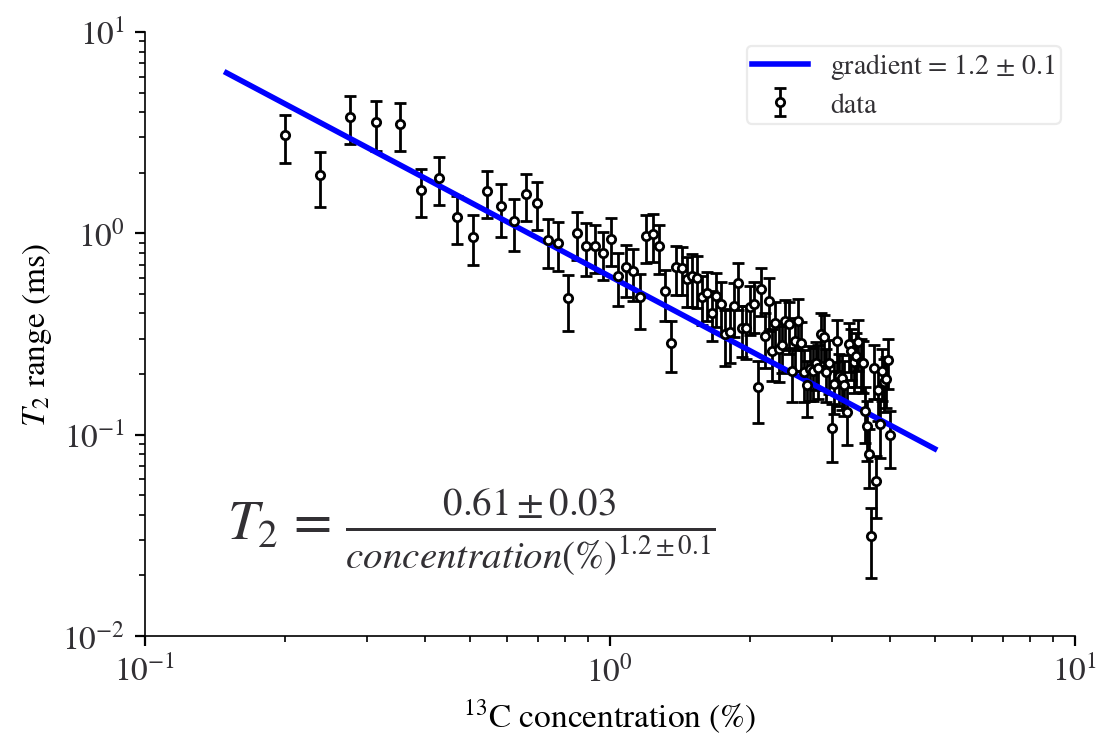

In [173]:
plt.figure()
plt.errorbar(concentration, T2_C_conc, yerr=T2_C_trueerr_conc, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
plt.plot(xfit,yfit,'b-',label='gradient = {0:0.1f} $\pm$ {1:0.1f}'.format(popt[1],np.sqrt(pcov[1][1])))
plt.ylabel('$T_2$ range (ms)')
plt.xlabel('$^{13}$C concentration (%)')
plt.xlim(0.1,10)
plt.ylim(0.01,10)
plt.text(0.15,0.03, r'$T_2$ = $\frac{{0.61\pm0.03}}{{concentration(\%)^{1.2\pm0.1}}}$', size = 20)
plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.title("T2 distribution for varying C-13 isotope concentrations on a single NV")

plt.savefig("T2distribution_0.002to0.04conc_seed8805.png")

# T2 range for varying distance between NV and one lone 14N impurity

In [58]:
""" T2 range for varying distance between NV and one lone 14N impurity """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range = []
for i in np.linspace(0.5, 4.0, repeats):
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [i, i, i])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range.append(popt)

    


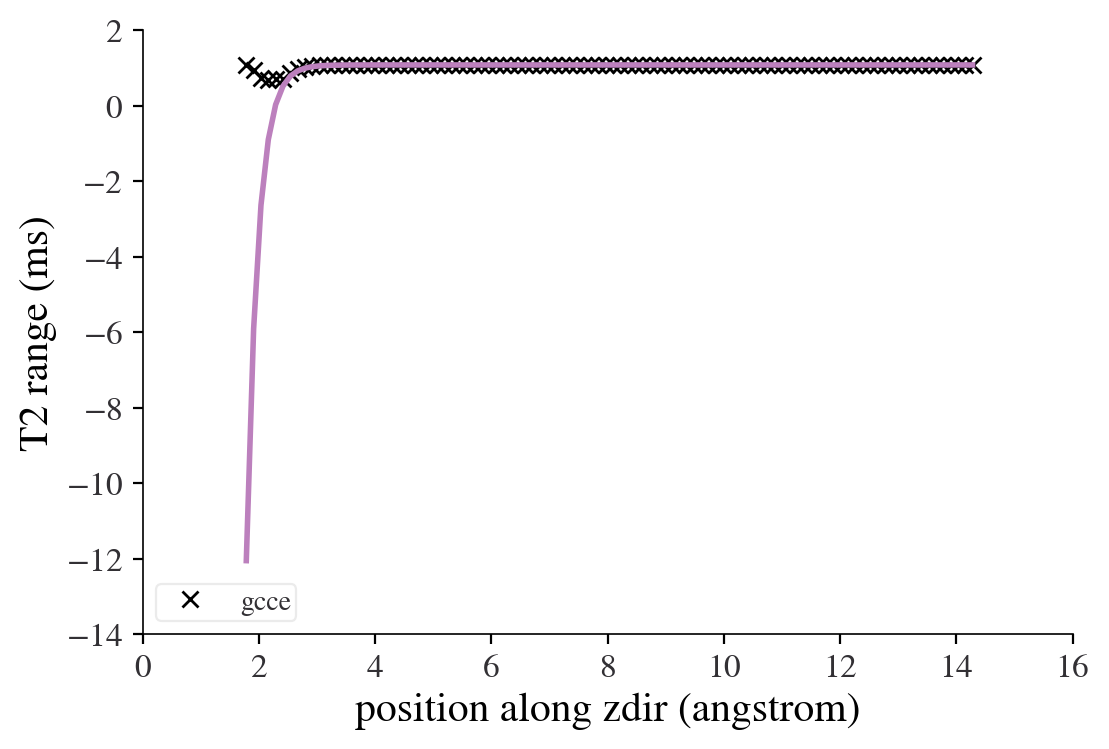

In [146]:
distances = np.linspace(0.5, 4.0, repeats)



inverseT2 = (np.array(T2_range))**(-1)
# print(inverseT2)
plt.figure()
plt.plot(distances*3.57, T2_range, 'rx', label='gcce')
plt.plot(distances*3.57, 1.085-1*np.exp(-5*(distances*3.57-2.3)))
plt.ylabel('T2 range (ms)',size=15)
plt.xlabel('position along zdir (angstrom)',size=15)
# plt.yscale("log")
# plt.xscale('log')
plt.legend()
#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")

In [18]:

""" inefficient assignment of impurities """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range = []

#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, 1.5, 1.5])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, 1.5, 1.5]),
                                       ('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, -0.5, 1.5]),
                                       ('14N',  [1.5, 1.5, 1.5]),('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, 1.5, -0.5]),
                                       ('14N',  [1.5, -0.5, 1.5]),('14N',  [1.5, 1.5, 1.5]),
                                       ('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, 0, 1.823]),
                                       ('14N',  [1.5, 1.5, -0.5]),('14N',  [1.5, -0.5, 1.5]),
                                       ('14N',  [1.5, 1.5, 1.5]),('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, 0.78, -0.886]),
                                       ('14N',  [1.5, 0, 1.823]),('14N',  [1.5, 1.5, -0.5]),
                                       ('14N',  [1.5, -0.5, 1.5]),('14N',  [1.5, 1.5, 1.5]),
                                       ('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, -0.854, 0.908]),
                                       ('14N',  [1.5, 0.78, -0.886]),('14N',  [1.5, 0, 1.823]),
                                       ('14N',  [1.5, 1.5, -0.5]),('14N',  [1.5, -0.5, 1.5]),
                                       ('14N',  [1.5, 1.5, 1.5]),('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, -0.4, -0.591]),
                                       ('14N',  [1.5, -0.854, 0.908]),('14N',  [1.5, 0.78, -0.886]),
                                       ('14N',  [1.5, 0, 1.823]),('14N',  [1.5, 1.5, -0.5]),
                                       ('14N',  [1.5, -0.5, 1.5]),('14N',  [1.5, 1.5, 1.5]),
                                       ('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
#########################################################################
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [1.5, -0.4, -0.591]),
                                       ('14N',  [1.5, -0.854, 0.908]),('14N',  [1.5, 0.78, -0.886]),
                                       ('14N',  [1.5, 0, 1.823]),('14N',  [1.5, 1.5, -0.5]),
                                       ('14N',  [1.5, -0.5, 1.5]),('14N',  [1.5, 1.5, 1.5]),
                                       ('14N',  [-0.5, -0.5, -0.5])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################


print(atoms['14N'])
print(T2_range)


[('14N', [ 0.     ,  0.     ,  3.09171], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 5.74326, -1.03974,  1.04912], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 2.99612, -5.40766,  3.20301], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 5.46107,  2.89067,  2.87323], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 0.4659 , -4.8891 ,  6.84917], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 4.12228,  4.12228,  5.15285], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 1.50886, -5.63114,  5.15285], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [ 0.     ,  0.     ,  9.27513], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.

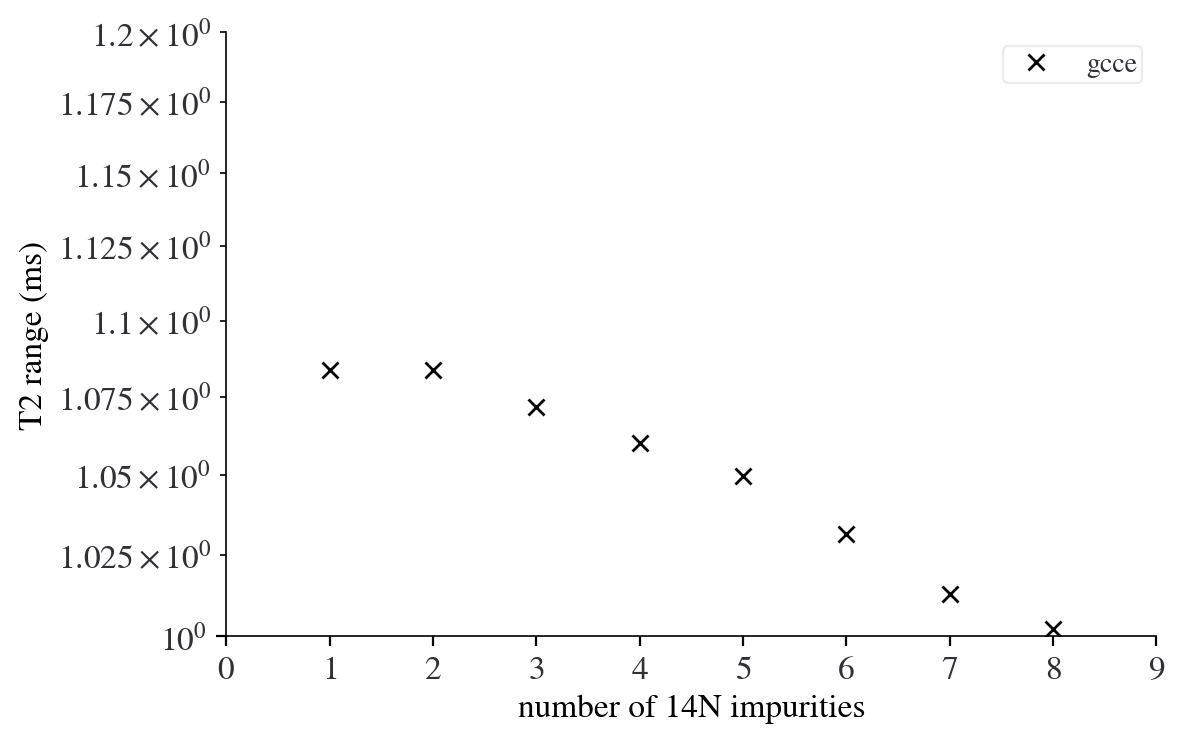

In [19]:
number = np.array([1,2,3,4,5,6,7,8])

plt.figure()
plt.plot(number, T2_range, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
plt.yscale('log')
plt.legend()
plt.xlim(0, 9)
plt.ylim(1.0, 1.2)
#plt.title("T2 distribution for varying number of 14N impurities at sqrt(2) or 1.414 angstrom from NV center")
plt.savefig("T2distribution_14N_1.414angs_8impure_fixedseed.png")

In [20]:

""" inefficient assignment of impurities """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range = []
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0, 1.1245]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, -0.124, 0]),
                                       ('14N',  [0.5, 0, 1.1245]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0, -0.1245]),
                                       ('14N',  [0.5, -0.124, 0]),('14N',  [0.5, 0, 1.1245]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, -0.3]),
                                       ('14N',  [0.5, 0, -0.1245]),('14N',  [0.5, -0.124, 0]),
                                       ('14N',  [0.5, 0, 1.1245]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.124, 0]),
                                       ('14N',  [0.5, 0.5, -0.3]),('14N',  [0.5, 0, -0.1245]),
                                       ('14N',  [0.5, -0.124, 0]),('14N',  [0.5, 0, 1.1245]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.993, 1.13]),
                                       ('14N',  [0.5, 1.124, 0]),('14N',  [0.5, 0.5, -0.3]),
                                       ('14N',  [0.5, 0, -0.1245]),('14N',  [0.5, -0.124, 0]),
                                       ('14N',  [0.5, 0, 1.1245]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.81, -0.2375]),
                                       ('14N',  [0.5, 0.993, 1.13]),('14N',  [0.5, 1.124, 0]),
                                       ('14N',  [0.5, 0.5, -0.3]),('14N',  [0.5, 0, -0.1245]),
                                       ('14N',  [0.5, -0.124, 0]),('14N',  [0.5, 0, 1.1245]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, -0.244, 0.794]),
                                       ('14N',  [0.5, 0.81, -0.2375]),('14N',  [0.5, 0.993, 1.13]),
                                       ('14N',  [0.5, 1.124, 0]),('14N',  [0.5, 0.5, -0.3]),
                                       ('14N',  [0.5, 0, -0.1245]),('14N',  [0.5, -0.124, 0]),
                                       ('14N',  [0.5, 0, 1.1245]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################


print(T2_range)


[array([1.04091]), array([0.86275]), array([0.26113]), array([0.00597]), array([0.00587]), array([0.82407]), array([0.74113]), array([0.73785]), array([0.94645])]


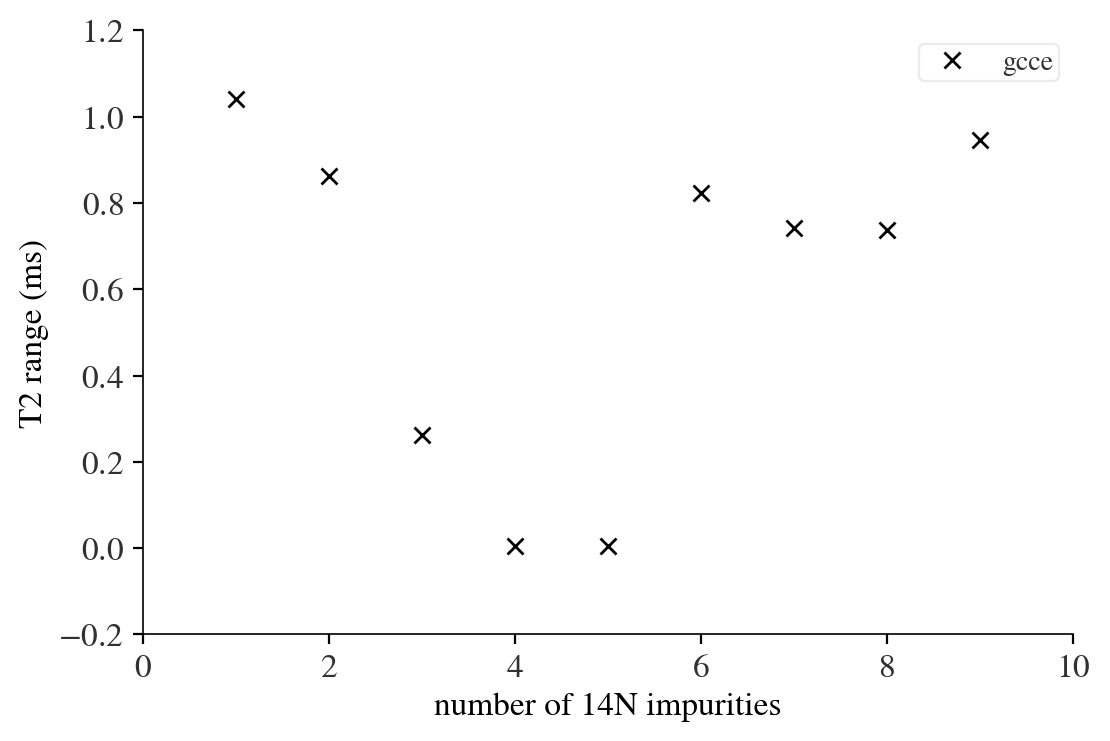

In [21]:
number = np.array([1,2,3,4,5,6,7,8,9])

plt.figure()
plt.plot(number, T2_range, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
plt.legend()
# plt.title("T2 distribution for varying number of 14N impurities at 0.8 angstrom from NV center")

plt.savefig("T2distribution_14N_0.8angs_9impurerandom_fixedseed.png")

In [29]:
""" random positions in two quadrants(top-right,bottom right) """
""" inefficient assignment of impurities """

#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1, -0.1244997998]),
                                       ('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 0.5, 1.3])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 0.5, 1.3])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.7, -0.2745966692]),('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 0.5, 1.3])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.6, -0.2937253933]),('14N',  [0.5, 0.7, -0.2745966692]),('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 0.5, 1.3])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)




print(T2_range)


[array([1.04091]), array([0.96033]), array([0.75664]), array([0.47719]), array([0.37254]), array([0.34312]), array([0.33449]), array([0.3246]), array([0.30658]), array([0.25452]), array([0.10003]), array([0.0129]), array([-0.00122]), array([1.]), array([0.25452]), array([0.10003]), array([0.0129]), array([300.99978]), array([-0.00122]), array([1.]), array([101.])]


In [ ]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

plt.figure()
plt.plot(number, T2_range, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
plt.legend()
#plt.title("T2 distribution for varying number of 14N impurities at 0.8 angstrom from NV center")

plt.savefig("T2distribution_14N_0.8angs_12impure_fixedseed.png")

In [27]:
""" random positions in right quadrants """
""" inefficient assignment of impurities """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range = []
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])], 
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                              seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 1, -0.1244997998]),
                                       ('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.9, -0.192820323]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=n_bath_states
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.8, -0.2416198487]),
                                       ('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),
                                       ('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.7, -0.2745966692]),
                                       ('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.9, -0.192820323]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.6, -0.2937253933]),
                                       ('14N',  [0.5, 0.7, -0.2745966692]),('14N',  [0.5, 0.8, -0.2416198487]),
                                       ('14N',  [0.5, 0.9, -0.192820323]),('14N',  [0.5, 1, -0.1244997998]),
                                       ('14N',  [0.5, 1.1, -0.02915026221]),('14N',  [0.5, 1.2, 0.1127016654]),
                                       ('14N',  [0.5, 1.3, 0.5]),('14N',  [0.5, 1.2, 0.8872983346]),
                                       ('14N',  [0.5, 1.1, 1.029150262]),('14N',  [0.5, 1, 1.1244998]),
                                       ('14N',  [0.5, 0.9, 1.192820323]),('14N',  [0.5, 0.8, 1.241619849]),
                                       ('14N',  [0.5, 0.7, 1.27459669]),('14N',  [0.5, 0.6, 1.293725393]),
                                       ('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)




print(T2_range)


[array([1.04091]), array([0.96033]), array([0.75664]), array([0.47719]), array([0.37254]), array([0.34312]), array([0.33449]), array([0.3246]), array([0.30658]), array([0.25452]), array([0.10003]), array([0.0129]), array([-0.00122]), array([1.])]


ValueError: x and y must have same first dimension, but have shapes (14,) and (1, 1)

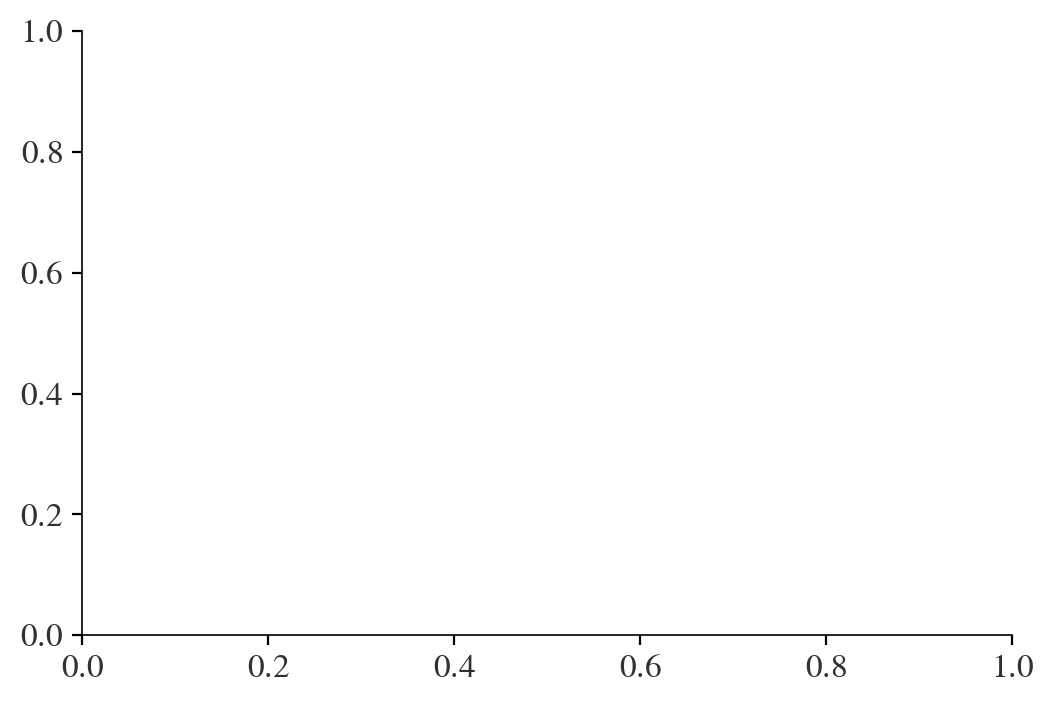

In [10]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,14,15])

plt.figure()
plt.plot(number, T2_range, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
plt.legend()
# plt.title("T2 distribution for varying number of 14N impurities at 0.8 angstrom from NV center")

plt.savefig("T2distribution_14N_0.8angs_16impure_fixedseed.png")

In [11]:
""" pseudo varied 14N impurity concentration """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

repeats = 50
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 30  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range = []
for i in np.linspace(0.001, 0.05, repeats):
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    diamond.add_atoms(('N', [0.75, 0.75, 0.25]))
    diamond.add_isotopes(('14N', i))
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range.append(popt)


print(atoms['N'])
print(T2_range)
concentration = np.linspace(0.001, 0.05, repeats)

plt.figure()
plt.plot(concentration, T2_range, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('14N impurity concentration')
plt.legend()
plt.title("T2 distribution for varying concentration of 14N impurities")

KeyboardInterrupt: 

In [ ]:
""" pseudo varied 14N impurity concentration """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

repeats = 50
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 30  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001
diamond.add_atoms(('N', [0.75, 0.75, 0.25]))
diamond.add_isotopes(('14N', 0.01))    # change concentration of 14N
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
plt.plot(time_space, l_gcce.real,
         label='coherence decay', ls='', marker='.')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.title("T2 distribution for varying concentration of 14N impurities")

# plt.savefig("coherence_decays_3.213angs_5.png")

In [ ]:

# "two NV centers"

# # Generate unitcell from ase
# diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
# diamond.zdir = [1,1,1]

# # Add types of isotopes
# diamond.add_isotopes(('13C', 0.011))
# diamond.isotopes['C']['14C'] = 0.001

# # Add the defect. remove and add atoms at the positions (in cell coordinates) 
# atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
#                                            ('C', [0.5, 0.5, 0.5])],
#                               add=('14N', [0.5, 0.5, 0.5]))

# atoms['14C'].gyro = 0
# atoms['14C'].spin = 0


# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# "setup for visualization and coherence calculation"

# # Parameters of CCE calculations engine

# # Order of CCE aproximation
# order = 2
# # Bath cutoff radius
# r_bath = 40  # in A
# # Cluster cutoff radius
# r_dipole = 6  # in A

# # position of central spin
# position = [0, 0, 0]
# # Qubit levels (in Sz basis)
# alpha = [0, 0, 1]; beta = [0, 1, 0]


# D = 2.88e6  # in kHz
# gyro = pc.ci['e'].gyro  # gyromagnetic ratio of electron in 10^7 rad/G/s

# # Generate an array of two central spins, 
# # each with the same D and gyromagnetic ratio value,
# # separated by 100 nm.
# nvs = pc.CenterArray(spin=[1, 1], D=[D, D], 
#                      position=[[0, 0, 0], [0, 0, 100]],
#                      gyro=[gyro, gyro], alpha=0, beta=2) 

# # print(nvs)  # Print properties of the central spin array

# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# # print(nvs[0], '\n')
# nvs[0].gyro = np.random.random((3,3)) * 1000
# # print(nvs)
# nvs[0].gyro = np.eye(3) * pc.ELECTRON_GYRO

# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# # Order of CCE aproximation
# order = 2
# # Bath cutoff radius
# r_bath = 40  # in A
# # Cluster cutoff radius
# r_dipole = 6  # in A

# bath = diamond.gen_supercell(200, remove=('C', [0,0,0]))

# bath2 = atoms.copy()
# bath2.z += 100


# calc = pc.Simulator(spin=nvs, bath=np.concatenate([bath, bath2]),
#                     r_bath=[r_bath, r_bath], r_dipole=r_dipole, order=order, magnetic_field=500)
# print(calc)


# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# # add 3D axis
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# # We want to visualize the smaller bath
# data = calc.bath

# # First plot the positions of the bath 
# #colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
# ax.scatter3D(data.x, data.y, data.z, cmap='viridis');
# # Plot all pairs of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 2
# for c in calc.clusters[2]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red')
# # Plot all triplets of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 3
# #for c in calc.clusters[3]:
#     #ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

# ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');